In [1]:
import pandas as pd

file_path = '/kaggle/input/instacart-grocery-orders/user_orders_product_food_category.csv'
df = pd.read_csv(file_path)

print("First 10 rows:")
print(df.head(10))
print("\n" + "="*50 + "\n")


print(f"Shape before removing 'ignore' rows: {df.shape}")
print("\n" + "="*50 + "\n")



First 10 rows:
   user_id  order_no                        food_category
0        1         1                               ignore
1        1         1  dairy substitutes or non-dairy milk
2        1         1                       beef deli meat
3        1         1                               ignore
4        1         1                               ignore
5        1         2                               ignore
6        1         2                              almonds
7        1         2                       beef deli meat
8        1         2                              bananas
9        1         2                               ignore


Shape before removing 'ignore' rows: (33819106, 3)




In [3]:

df_filtered = df[df['food_category'] != 'ignore']


print(f"Shape after removing 'ignore' rows: {df_filtered.shape}")
print("\n" + "="*50 + "\n")


print("First 10 rows after filtering:")
print(df_filtered.head(15))

Shape after removing 'ignore' rows: (24432499, 3)


First 10 rows after filtering:
    user_id  order_no                        food_category
1         1         1  dairy substitutes or non-dairy milk
2         1         1                       beef deli meat
6         1         2                              almonds
7         1         2                       beef deli meat
8         1         2                              bananas
12        1         3                       beef deli meat
13        1         3                              almonds
14        1         3                     processed cheese
15        1         3    other nut paste, butter or spread
17        1         4                       beef deli meat
18        1         4                              almonds
19        1         4                     processed cheese
22        1         5                       beef deli meat
23        1         5                              almonds
24        1         5           

In [28]:
"""
Data Processing Block - Run this ONCE
Processes user sequences and saves them for future use
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pickle
from typing import List, Tuple, Optional

class DataProcessor:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.label_encoder = LabelEncoder()
        
    def prepare_dataset(self, dataset_fraction: float = 0.5) -> Tuple[List[str], np.ndarray]:
        print("Sampling users...")
        unique_users = self.df['user_id'].unique()
        num_users_to_sample = int(len(unique_users) * dataset_fraction)
        sampled_users = np.random.choice(unique_users, size=num_users_to_sample, replace=False)
        
        working_df = self.df[self.df['user_id'].isin(sampled_users)]
        
        all_categories = working_df['food_category'].unique()
        self.label_encoder.fit(all_categories)
        
        print("Creating sequences...")
        user_sequences, labels = self._create_sequences(working_df, sampled_users)
        
        return user_sequences, np.array(labels)
    
    def _create_sequences(self, df: pd.DataFrame, user_ids: np.ndarray) -> Tuple[List[str], List[int]]:
        user_sequences = []
        labels = []
        
        for user_id in tqdm(user_ids, desc="Processing users"):
            user_data = df[df['user_id'] == user_id].sort_values('order_no')
            
            if len(user_data) < 2:
                continue
                
            input_sequence = self._build_input_sequence(user_data)
            label = self._get_label(user_data)
            
            if label is not None:
                user_sequences.append(input_sequence)
                labels.append(label)
        
        return user_sequences, labels
    
    def _build_input_sequence(self, user_data: pd.DataFrame) -> str:
        input_orders = user_data[user_data['order_no'] < user_data['order_no'].max()]
        sequence_parts = []
        
        for order_no, order_data in input_orders.groupby('order_no'):
            order_items = " | ".join(order_data['food_category'].tolist())
            sequence_parts.append(f"Order {order_no}: {order_items}")
        
        return " [SEP] ".join(sequence_parts)
    
    def _get_label(self, user_data: pd.DataFrame) -> Optional[int]:
        last_order = user_data[user_data['order_no'] == user_data['order_no'].max()]
        last_order_categories = last_order['food_category'].value_counts()
        
        if len(last_order_categories) > 0:
            most_frequent_category = last_order_categories.index[0]
            return self.label_encoder.transform([most_frequent_category])[0]
        return None

# Process and save the data (RUN THIS ONLY ONCE)
print("Starting data processing...")
processor = DataProcessor(df_filtered)
all_sequences, all_labels = processor.prepare_dataset(dataset_fraction=0.5)

# Save processed data
processed_data = {
    'sequences': all_sequences,
    'labels': all_labels,
    'label_encoder': processor.label_encoder
}

with open('processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("Data processing completed!")
print(f"Total sequences: {len(all_sequences)}")
print(f"Number of classes: {len(processor.label_encoder.classes_)}")
print("Data saved to 'processed_data.pkl'")



Starting data processing...
Sampling users...
Creating sequences...


Processing users: 100%|██████████| 102640/102640 [19:04<00:00, 89.65it/s]


Data processing completed!
Total sequences: 102287
Number of classes: 195
Data saved to 'processed_data.pkl'


In [1]:
"""
Quick Setup Block - Run this for each hyperparameter tuning experiment
Loads pre-processed data and sets up data loaders
"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pickle
from typing import List, Tuple, Optional

import pickle
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

class TrainingConfig:
    # Hyperparameters - CHANGE THESE FOR EACH EXPERIMENT
    MODEL_NAME = "prajjwal1/bert-mini"
    BATCH_SIZE = 64
    LEARNING_RATE = 5e-5
    NUM_EPOCHS = 10
    HIDDEN_DIM = 512
    DROPOUT_RATE = 0.3
    WEIGHT_DECAY = 0.01
    WARMUP_STEPS = 500
    GRAD_CLIP = 1.0
    PATIENCE = 5
    
    # Data
    MAX_SEQUENCE_LENGTH = 256
    TEST_SIZE = 0.15
    RANDOM_STATE = 42
    
    # System
    USE_MULTI_GPU = True
    SAVE_DIR = "./experiment_models"

class FoodDataset(Dataset):
    def __init__(self, sequences: list, labels: np.ndarray, tokenizer: AutoTokenizer):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.sequences[idx],
            truncation=True,
            padding='max_length',
            max_length=TrainingConfig.MAX_SEQUENCE_LENGTH,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Load processed data
print("Loading pre-processed data...")
with open('/kaggle/input/pre-trainedsequence/processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

all_sequences = processed_data['sequences']
all_labels = processed_data['labels']
label_encoder = processed_data['label_encoder']

# Quick train/val split
train_sequences, val_sequences, train_labels, val_labels = train_test_split(
    all_sequences, all_labels, 
    test_size=TrainingConfig.TEST_SIZE, 
    random_state=TrainingConfig.RANDOM_STATE
)

# Setup tokenizer
tokenizer = AutoTokenizer.from_pretrained(TrainingConfig.MODEL_NAME)
if tokenizer.sep_token is None:
    tokenizer.sep_token = '[SEP]'

# Create data loaders
train_dataset = FoodDataset(train_sequences, train_labels, tokenizer)
val_dataset = FoodDataset(val_sequences, val_labels, tokenizer)

train_loader = DataLoader(
    train_dataset,
    batch_size=TrainingConfig.BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TrainingConfig.BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Setup device
if not torch.cuda.is_available():
    device = torch.device('cpu')
    world_size = 1
else:
    available_gpus = torch.cuda.device_count()
    if TrainingConfig.USE_MULTI_GPU and available_gpus > 1:
        device = torch.device('cuda')
        world_size = available_gpus
        print(f"Using DataParallel across {world_size} GPUs")
    else:
        device = torch.device('cuda:0')
        world_size = 1
        print(f"Using single GPU")

total_steps = len(train_loader) * TrainingConfig.NUM_EPOCHS

print("Setup completed!")
print(f"Training sequences: {len(train_sequences)}")
print(f"Validation sequences: {len(val_sequences)}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Batch size: {TrainingConfig.BATCH_SIZE}")
print(f"Model: {TrainingConfig.MODEL_NAME}")
print(f"Learning rate: {TrainingConfig.LEARNING_RATE}")
print(f"GPUs: {world_size}")

Loading pre-processed data...


config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Using DataParallel across 2 GPUs
Setup completed!
Training sequences: 86943
Validation sequences: 15344
Number of classes: 195
Batch size: 64
Model: prajjwal1/bert-mini
Learning rate: 5e-05
GPUs: 2


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Model wrapped with DataParallel
Starting training with current configuration...
Model: prajjwal1/bert-mini
Batch size: 64
Learning rate: 5e-05
Hidden dim: 512


Epoch 1/10 [Train]:   0%|          | 0/1359 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Epoch 1/10 [Val]: 100%|██████████| 240/240 [00:14<00:00, 16.28it/s, Acc=16.08%]


Epoch 1/10:
  Train Loss: 5.0983 | Train Acc: 8.61%
  Val Loss: 4.4888 | Val Acc: 16.08%
  Top-5 Acc: 35.74% | Top-10 Acc: 45.74%
  Learning Rate: 4.67e-05
  Epoch Time: 148.96s
  --------------------------------------------------
  New best model saved! Accuracy: 16.08%


Epoch 2/10 [Val]: 100%|██████████| 240/240 [00:14<00:00, 16.40it/s, Acc=17.81%]


Epoch 2/10:
  Train Loss: 4.4730 | Train Acc: 15.89%
  Val Loss: 4.1369 | Val Acc: 17.81%
  Top-5 Acc: 39.85% | Top-10 Acc: 51.97%
  Learning Rate: 4.15e-05
  Epoch Time: 143.47s
  --------------------------------------------------
  New best model saved! Accuracy: 17.81%


Epoch 3/10 [Val]: 100%|██████████| 240/240 [00:14<00:00, 16.18it/s, Acc=17.59%]


Epoch 3/10:
  Train Loss: 4.1814 | Train Acc: 17.01%
  Val Loss: 3.9843 | Val Acc: 17.59%
  Top-5 Acc: 41.25% | Top-10 Acc: 53.62%
  Learning Rate: 3.63e-05
  Epoch Time: 144.20s
  --------------------------------------------------
  No improvement for 1 epoch(s)


Epoch 4/10 [Val]: 100%|██████████| 240/240 [00:14<00:00, 16.37it/s, Acc=18.48%]


Epoch 4/10:
  Train Loss: 3.9846 | Train Acc: 17.54%
  Val Loss: 3.8314 | Val Acc: 18.48%
  Top-5 Acc: 42.58% | Top-10 Acc: 55.19%
  Learning Rate: 3.11e-05
  Epoch Time: 144.39s
  --------------------------------------------------
  New best model saved! Accuracy: 18.48%


Epoch 5/10 [Val]: 100%|██████████| 240/240 [00:15<00:00, 15.77it/s, Acc=18.20%]


Epoch 5/10:
  Train Loss: 3.8564 | Train Acc: 17.93%
  Val Loss: 3.7534 | Val Acc: 18.20%
  Top-5 Acc: 43.53% | Top-10 Acc: 56.14%
  Learning Rate: 2.60e-05
  Epoch Time: 144.55s
  --------------------------------------------------
  No improvement for 1 epoch(s)


Epoch 6/10 [Val]: 100%|██████████| 240/240 [00:14<00:00, 16.35it/s, Acc=18.42%]


Epoch 6/10:
  Train Loss: 3.7739 | Train Acc: 18.54%
  Val Loss: 3.7121 | Val Acc: 18.42%
  Top-5 Acc: 43.97% | Top-10 Acc: 56.73%
  Learning Rate: 2.08e-05
  Epoch Time: 142.97s
  --------------------------------------------------
  No improvement for 2 epoch(s)


Epoch 7/10 [Val]: 100%|██████████| 240/240 [00:14<00:00, 16.39it/s, Acc=18.89%]


Epoch 7/10:
  Train Loss: 3.7224 | Train Acc: 18.59%
  Val Loss: 3.6784 | Val Acc: 18.89%
  Top-5 Acc: 44.38% | Top-10 Acc: 57.05%
  Learning Rate: 1.56e-05
  Epoch Time: 143.99s
  --------------------------------------------------
  New best model saved! Accuracy: 18.89%


Epoch 8/10 [Val]: 100%|██████████| 240/240 [00:14<00:00, 16.42it/s, Acc=18.96%]


Epoch 8/10:
  Train Loss: 3.6848 | Train Acc: 19.12%
  Val Loss: 3.6707 | Val Acc: 18.96%
  Top-5 Acc: 44.70% | Top-10 Acc: 57.55%
  Learning Rate: 1.04e-05
  Epoch Time: 143.97s
  --------------------------------------------------
  New best model saved! Accuracy: 18.96%


Epoch 9/10 [Val]: 100%|██████████| 240/240 [00:15<00:00, 15.69it/s, Acc=18.94%]


Epoch 9/10:
  Train Loss: 3.6664 | Train Acc: 19.19%
  Val Loss: 3.6612 | Val Acc: 18.94%
  Top-5 Acc: 44.75% | Top-10 Acc: 57.49%
  Learning Rate: 5.19e-06
  Epoch Time: 145.03s
  --------------------------------------------------
  No improvement for 1 epoch(s)


Epoch 10/10 [Val]: 100%|██████████| 240/240 [00:16<00:00, 14.68it/s, Acc=18.93%]


Epoch 10/10:
  Train Loss: 3.6470 | Train Acc: 19.42%
  Val Loss: 3.6621 | Val Acc: 18.93%
  Top-5 Acc: 44.65% | Top-10 Acc: 57.61%
  Learning Rate: 0.00e+00
  Epoch Time: 148.44s
  --------------------------------------------------
  No improvement for 2 epoch(s)
Training completed in 1451.78s
Best validation accuracy: 18.96%


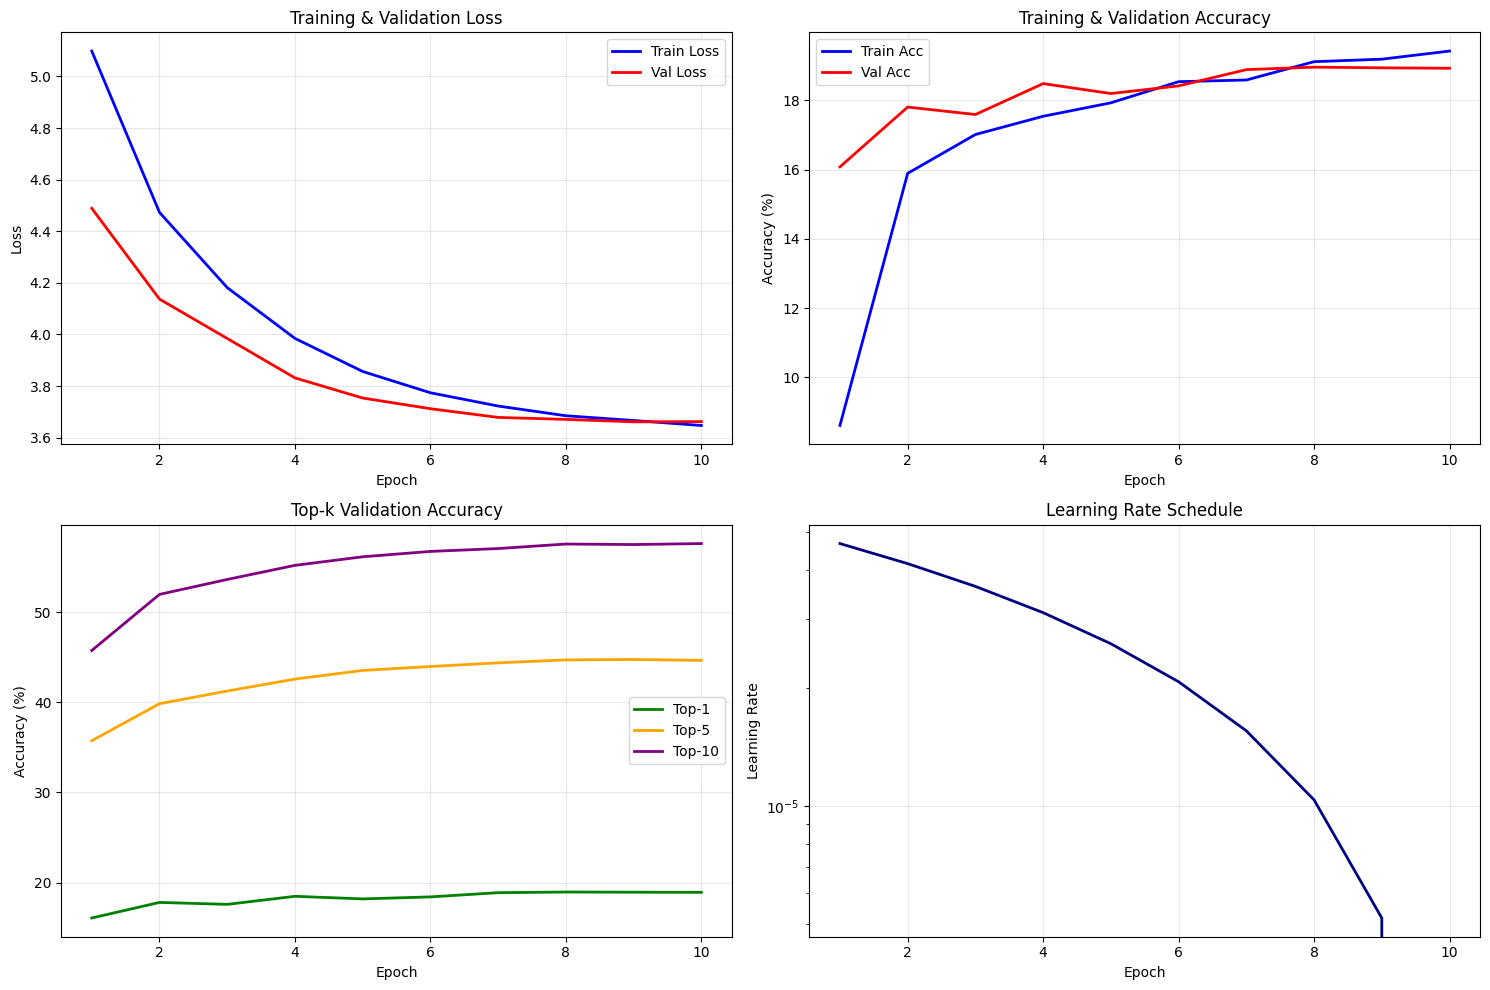

Experiment completed!


In [2]:
"""
Training Block - Run this for each hyperparameter tuning experiment
Trains the model with the current configuration
"""

import torch.nn as nn
import torch.optim as optim
from transformers import AutoModel, get_linear_schedule_with_warmup
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os

class FoodCategoryClassifier(nn.Module):
    def __init__(self, model_name: str, num_classes: int):
        super().__init__()
        
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(TrainingConfig.DROPOUT_RATE)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, TrainingConfig.HIDDEN_DIM),
            nn.ReLU(),
            nn.BatchNorm1d(TrainingConfig.HIDDEN_DIM),
            nn.Dropout(TrainingConfig.DROPOUT_RATE),
            nn.Linear(TrainingConfig.HIDDEN_DIM, num_classes)
        )
        
    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

class ParallelTrainer:
    def __init__(self):
        self.model = FoodCategoryClassifier(TrainingConfig.MODEL_NAME, len(label_encoder.classes_))
        self.model = self.model.to(device)
        
        # DataParallel for multi-GPU
        if world_size > 1:
            self.model = nn.DataParallel(self.model)
            print("Model wrapped with DataParallel")
        
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=TrainingConfig.LEARNING_RATE,
            weight_decay=TrainingConfig.WEIGHT_DECAY
        )
        
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=TrainingConfig.WARMUP_STEPS,
            num_training_steps=total_steps
        )
        
        self.criterion = nn.CrossEntropyLoss()
        
        self.metrics = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [], 'val_top5_acc': [], 'val_top10_acc': [],
            'learning_rates': [], 'epoch_times': []
        }
        self.best_val_acc = 0
        self.patience_counter = 0
        
    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{TrainingConfig.NUM_EPOCHS} [Train]')
        
        for batch in train_pbar:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)
            
            self.optimizer.zero_grad()
            
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            loss = self.criterion(outputs, labels)
            
            if torch.isnan(loss):
                print("NaN loss detected, skipping batch")
                continue
                
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), TrainingConfig.GRAD_CLIP)
            self.optimizer.step()
            self.scheduler.step()
            
            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels).sum().item()
            
            total_loss += loss.item()
            correct_predictions += batch_correct
            total_samples += labels.size(0)
            
            current_acc = 100 * correct_predictions / total_samples
            current_lr = self.scheduler.get_last_lr()[0]
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%',
                'LR': f'{current_lr:.2e}'
            })
        
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct_predictions / total_samples
        
        return avg_loss, accuracy
    
    def validate_epoch(self, epoch):
        self.model.eval()
        total_loss = 0
        correct_predictions = 0
        top5_correct = 0
        top10_correct = 0
        total_samples = 0
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{TrainingConfig.NUM_EPOCHS} [Val]')
        
        with torch.no_grad():
            for batch in val_pbar:
                input_ids = batch['input_ids'].to(device, non_blocking=True)
                attention_mask = batch['attention_mask'].to(device, non_blocking=True)
                labels = batch['labels'].to(device, non_blocking=True)
                
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                loss = self.criterion(outputs, labels)
                
                total_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                batch_correct = (predicted == labels).sum().item()
                correct_predictions += batch_correct
                
                # Top-5 and Top-10 accuracy
                _, top5_pred = torch.topk(outputs, 5, dim=1)
                _, top10_pred = torch.topk(outputs, 10, dim=1)
                
                batch_top5_correct = sum(1 for i, label in enumerate(labels) if label in top5_pred[i])
                batch_top10_correct = sum(1 for i, label in enumerate(labels) if label in top10_pred[i])
                
                top5_correct += batch_top5_correct
                top10_correct += batch_top10_correct
                total_samples += labels.size(0)
                
                current_acc = 100 * correct_predictions / total_samples
                val_pbar.set_postfix({'Acc': f'{current_acc:.2f}%'})
        
        avg_loss = total_loss / len(val_loader)
        accuracy = 100 * correct_predictions / total_samples
        top5_accuracy = 100 * top5_correct / total_samples
        top10_accuracy = 100 * top10_correct / total_samples
        
        return avg_loss, accuracy, top5_accuracy, top10_accuracy
    
    def train(self):
        print("Starting training with current configuration...")
        print(f"Model: {TrainingConfig.MODEL_NAME}")
        print(f"Batch size: {TrainingConfig.BATCH_SIZE}")
        print(f"Learning rate: {TrainingConfig.LEARNING_RATE}")
        print(f"Hidden dim: {TrainingConfig.HIDDEN_DIM}")
        
        start_time = time.time()
        
        for epoch in range(TrainingConfig.NUM_EPOCHS):
            epoch_start = time.time()
            
            # Training
            train_loss, train_acc = self.train_epoch(epoch)
            
            # Validation
            val_loss, val_acc, top5_acc, top10_acc = self.validate_epoch(epoch)
            
            epoch_time = time.time() - epoch_start
            
            # Update metrics
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_acc'].append(train_acc)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_acc'].append(val_acc)
            self.metrics['val_top5_acc'].append(top5_acc)
            self.metrics['val_top10_acc'].append(top10_acc)
            self.metrics['learning_rates'].append(self.scheduler.get_last_lr()[0])
            self.metrics['epoch_times'].append(epoch_time)
            
            # Print epoch summary
            print(f'Epoch {epoch+1}/{TrainingConfig.NUM_EPOCHS}:')
            print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
            print(f'  Top-5 Acc: {top5_acc:.2f}% | Top-10 Acc: {top10_acc:.2f}%')
            print(f'  Learning Rate: {self.scheduler.get_last_lr()[0]:.2e}')
            print(f'  Epoch Time: {epoch_time:.2f}s')
            print('  ' + '-' * 50)
            
            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.patience_counter = 0
                self._save_checkpoint(epoch, val_acc)
                print(f'  New best model saved! Accuracy: {val_acc:.2f}%')
            else:
                self.patience_counter += 1
                print(f'  No improvement for {self.patience_counter} epoch(s)')
            
            # Early stopping
            if self.patience_counter >= TrainingConfig.PATIENCE:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break
        
        total_time = time.time() - start_time
        print(f'Training completed in {total_time:.2f}s')
        print(f'Best validation accuracy: {self.best_val_acc:.2f}%')
        
        self._plot_training_metrics()
        
        return self.metrics
    
    def _save_checkpoint(self, epoch, accuracy):
        if not os.path.exists(TrainingConfig.SAVE_DIR):
            os.makedirs(TrainingConfig.SAVE_DIR)
        
        # Handle DataParallel wrapper
        if isinstance(self.model, nn.DataParallel):
            model_state_dict = self.model.module.state_dict()
        else:
            model_state_dict = self.model.state_dict()
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'accuracy': accuracy,
            'metrics': self.metrics,
            'label_encoder': label_encoder,
            'config': {k: v for k, v in vars(TrainingConfig).items() if not k.startswith('_')}
        }
        
        torch.save(checkpoint, os.path.join(TrainingConfig.SAVE_DIR, 'best_model.pth'))
    
    def _plot_training_metrics(self):
        epochs = range(1, len(self.metrics['train_loss']) + 1)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss
        ax1.plot(epochs, self.metrics['train_loss'], 'b-', label='Train Loss', linewidth=2)
        ax1.plot(epochs, self.metrics['val_loss'], 'r-', label='Val Loss', linewidth=2)
        ax1.set_title('Training & Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy
        ax2.plot(epochs, self.metrics['train_acc'], 'b-', label='Train Acc', linewidth=2)
        ax2.plot(epochs, self.metrics['val_acc'], 'r-', label='Val Acc', linewidth=2)
        ax2.set_title('Training & Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Top-k Accuracy
        ax3.plot(epochs, self.metrics['val_acc'], 'g-', label='Top-1', linewidth=2)
        ax3.plot(epochs, self.metrics['val_top5_acc'], 'orange', label='Top-5', linewidth=2)
        ax3.plot(epochs, self.metrics['val_top10_acc'], 'purple', label='Top-10', linewidth=2)
        ax3.set_title('Top-k Validation Accuracy')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy (%)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Learning Rate
        ax4.plot(epochs, self.metrics['learning_rates'], 'navy', linewidth=2)
        ax4.set_title('Learning Rate Schedule')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Learning Rate')
        ax4.set_yscale('log')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(TrainingConfig.SAVE_DIR, 'training_metrics.png'), dpi=300, bbox_inches='tight')
        plt.show()

# Start training with current configuration
trainer = ParallelTrainer()
metrics = trainer.train()

print("Experiment completed!")

In [3]:
"""
Litmus Test - Multiple Examples
"""

print("=== LITMUS TEST - MULTIPLE EXAMPLES ===\n")

for i in range(3):  # Show first 3 examples
    sample_sequence = train_sequences[i]
    sample_label = train_labels[i]
    true_category = label_encoder.inverse_transform([sample_label])[0]
    
    print(f"Example {i+1}:")
    print(f"Input: {sample_sequence[:100]}...")
    print(f"Target: '{true_category}' (index {sample_label})")
    print("-" * 80)

=== LITMUS TEST - MULTIPLE EXAMPLES ===

Example 1:
Input: Order 1: almonds | bananas | granola bars, power bars, or protein bars | hazelnuts | chocolate or ch...
Target: 'yogurt' (index 193)
--------------------------------------------------------------------------------
Example 2:
Input: Order 1: apples | green or yellow beans | green or yellow beans | green or yellow beans | raspberrie...
Target: 'lettuce or leafy greens' (index 101)
--------------------------------------------------------------------------------
Example 3:
Input: Order 1: raw milk cheese | fruit smoothies | fresh basil | cucumbers | store bought salsa | tomatoes...
Target: 'store bought salsa' (index 170)
--------------------------------------------------------------------------------


In [4]:
"""
Process the second half of the dataset
Run this to process the remaining 50% of users
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pickle
from typing import List, Tuple, Optional

print("Loading filtered data...")
file_path = '/kaggle/input/instacart-grocery-orders/user_orders_product_food_category.csv'
df = pd.read_csv(file_path)
df_filtered = df[df['food_category'] != 'ignore']

class DataProcessor:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.label_encoder = LabelEncoder()
        
    def prepare_dataset(self, dataset_fraction: float = 0.5, random_state: int = 42) -> Tuple[List[str], np.ndarray]:
        print("Sampling users...")
        unique_users = self.df['user_id'].unique()
        num_users_to_sample = int(len(unique_users) * dataset_fraction)
        
        # Use different random seed to get the other half
        np.random.seed(random_state)
        sampled_users = np.random.choice(unique_users, size=num_users_to_sample, replace=False)
        
        working_df = self.df[self.df['user_id'].isin(sampled_users)]
        
        # Load existing label encoder to ensure consistency
        with open('/kaggle/input/pre-trainedsequence/processed_data.pkl', 'rb') as f:
            existing_data = pickle.load(f)
            self.label_encoder = existing_data['label_encoder']
        
        print("Creating sequences...")
        user_sequences, labels = self._create_sequences(working_df, sampled_users)
        
        return user_sequences, np.array(labels)
    
    def _create_sequences(self, df: pd.DataFrame, user_ids: np.ndarray) -> Tuple[List[str], List[int]]:
        user_sequences = []
        labels = []
        
        for user_id in tqdm(user_ids, desc="Processing users"):
            user_data = df[df['user_id'] == user_id].sort_values('order_no')
            
            if len(user_data) < 2:
                continue
                
            input_sequence = self._build_input_sequence(user_data)
            label = self._get_label(user_data)
            
            if label is not None:
                user_sequences.append(input_sequence)
                labels.append(label)
        
        return user_sequences, labels
    
    def _build_input_sequence(self, user_data: pd.DataFrame) -> str:
        input_orders = user_data[user_data['order_no'] < user_data['order_no'].max()]
        sequence_parts = []
        
        for order_no, order_data in input_orders.groupby('order_no'):
            order_items = " | ".join(order_data['food_category'].tolist())
            sequence_parts.append(f"Order {order_no}: {order_items}")
        
        return " [SEP] ".join(sequence_parts)
    
    def _get_label(self, user_data: pd.DataFrame) -> Optional[int]:
        last_order = user_data[user_data['order_no'] == user_data['order_no'].max()]
        last_order_categories = last_order['food_category'].value_counts()
        
        if len(last_order_categories) > 0:
            most_frequent_category = last_order_categories.index[0]
            return self.label_encoder.transform([most_frequent_category])[0]
        return None

print("\n" + "="*80)
print("PROCESSING SECOND HALF OF DATASET")
print("="*80 + "\n")

processor = DataProcessor(df_filtered)

# Use different random seed (999) to get different users than first half
second_half_sequences, second_half_labels = processor.prepare_dataset(
    dataset_fraction=0.5, 
    random_state=999  # Different seed from first processing
)

# Save second half data
second_half_data = {
    'sequences': second_half_sequences,
    'labels': second_half_labels,
    'label_encoder': processor.label_encoder
}

with open('processed_data_second_half.pkl', 'wb') as f:
    pickle.dump(second_half_data, f)

print(f"\nSecond half processing completed!")
print(f"Second half sequences: {len(second_half_sequences)}")
print(f"Second half labels: {len(second_half_labels)}")
print(f"Number of classes: {len(processor.label_encoder.classes_)}")
print(f"Data saved to 'processed_data_second_half.pkl'")

Loading filtered data...

PROCESSING SECOND HALF OF DATASET

Sampling users...
Creating sequences...


Processing users: 100%|██████████| 102640/102640 [18:50<00:00, 90.76it/s]



Second half processing completed!
Second half sequences: 102300
Second half labels: 102300
Number of classes: 195
Data saved to 'processed_data_second_half.pkl'


In [8]:
"""
Combine both halves of processed data into complete dataset
"""

import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

print("Loading both halves of processed data...\n")

# Load first half
with open('/kaggle/input/pre-trainedsequence/processed_data.pkl', 'rb') as f:
    first_half_data = pickle.load(f)
    print(f"First half sequences: {len(first_half_data['sequences'])}")

# Load second half
with open('processed_data_second_half.pkl', 'rb') as f:
    second_half_data = pickle.load(f)
    print(f"Second half sequences: {len(second_half_data['sequences'])}")

# Verify label encoders match
if np.array_equal(first_half_data['label_encoder'].classes_, 
                   second_half_data['label_encoder'].classes_):
    print("✓ Label encoders match")
    label_encoder = first_half_data['label_encoder']
else:
    print("⚠️ Warning: Label encoders don't match! Using first half's encoder")
    label_encoder = first_half_data['label_encoder']

# Combine data
all_sequences = first_half_data['sequences'] + second_half_data['sequences']
all_labels = np.concatenate([first_half_data['labels'], second_half_data['labels']])

print(f"\nCombined dataset statistics:")
print(f"Total sequences: {len(all_sequences)}")
print(f"Total labels: {len(all_labels)}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Check class distribution
label_counts = Counter(all_labels)
print(f"\nChecking class distribution...")

# Find classes with only 1 sample
singleton_classes = [cls for cls, count in label_counts.items() if count == 1]
print(f"Classes with only 1 sample: {len(singleton_classes)}")

if singleton_classes:
    print("Removing singleton classes to enable stratified splitting...")
    
    # Create masks for samples that are NOT in singleton classes
    mask = np.array([label not in singleton_classes for label in all_labels])
    
    # Filter data
    all_sequences = [seq for seq, keep in zip(all_sequences, mask) if keep]
    all_labels = all_labels[mask]
    
    print(f"After removing singleton classes:")
    print(f"  Remaining sequences: {len(all_sequences)}")
    print(f"  Remaining labels: {len(all_labels)}")
    print(f"  Remaining classes: {len(set(all_labels))}")
    
    # Update label_counts
    label_counts = Counter(all_labels)

# Verify we have at least 2 samples per class
min_samples = min(label_counts.values())
print(f"\nMinimum samples per class: {min_samples}")

if min_samples < 2:
    print("Warning: Still have classes with < 2 samples. Cannot use stratification.")
    use_stratify = False
else:
    print("✓ All classes have at least 2 samples. Can use stratification.")
    use_stratify = True

# Split into train/validation (85/15 split)
print(f"\nSplitting dataset (85% train, 15% validation)...")

if use_stratify:
    train_sequences, val_sequences, train_labels, val_labels = train_test_split(
        all_sequences, all_labels, 
        test_size=0.15, 
        random_state=42,
        stratify=all_labels  # Maintain class distribution
    )
    print("Used stratified splitting")
else:
    train_sequences, val_sequences, train_labels, val_labels = train_test_split(
        all_sequences, all_labels, 
        test_size=0.15, 
        random_state=42
    )
    print("Used random splitting (no stratification)")

print(f"\nTrain/Validation Split:")
print(f"Training sequences: {len(train_sequences)} ({len(train_sequences)/len(all_sequences)*100:.1f}%)")
print(f"Validation sequences: {len(val_sequences)} ({len(val_sequences)/len(all_sequences)*100:.1f}%)")

# Check class distribution in splits
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

print(f"\nClass distribution in splits:")
print(f"{'Class':<40} {'Train':<8} {'Val':<8} {'Total':<8} {'Train %':<10} {'Val %':<10}")
print("-" * 90)

for class_id, class_name in enumerate(label_encoder.classes_):
    if class_id in train_counts or class_id in val_counts:
        train_count = train_counts.get(class_id, 0)
        val_count = val_counts.get(class_id, 0)
        total = train_count + val_count
        train_pct = train_count / total * 100 if total > 0 else 0
        val_pct = val_count / total * 100 if total > 0 else 0
        
        print(f"{class_name[:38]:<40} {train_count:<8} {val_count:<8} {total:<8} {train_pct:<10.1f} {val_pct:<10.1f}")

# Save combined dataset
full_dataset = {
    'train_sequences': train_sequences,
    'train_labels': train_labels,
    'val_sequences': val_sequences,
    'val_labels': val_labels,
    'label_encoder': label_encoder,
    'all_sequences': all_sequences,
    'all_labels': all_labels,
    'singleton_classes_removed': len(singleton_classes) > 0,
    'num_singleton_classes': len(singleton_classes)
}

with open('full_processed_dataset.pkl', 'wb') as f:
    pickle.dump(full_dataset, f)

print(f"\n✓ Full dataset saved to 'full_processed_dataset.pkl'")
print(f"✓ Singleton classes removed: {len(singleton_classes)}")

# Show top 10 most common classes
print(f"\n📊 Top 10 most common classes (after processing):")
top_classes = label_counts.most_common(10)
for rank, (class_id, count) in enumerate(top_classes, 1):
    class_name = label_encoder.inverse_transform([class_id])[0]
    percentage = count / len(all_labels) * 100
    print(f"  {rank:2}. {class_name[:45]:<45} {count:>6} samples ({percentage:.2f}%)")

Loading both halves of processed data...

First half sequences: 102287
Second half sequences: 102300
✓ Label encoders match

Combined dataset statistics:
Total sequences: 204587
Total labels: 204587
Number of classes: 195

Checking class distribution...
Classes with only 1 sample: 4
Removing singleton classes to enable stratified splitting...
After removing singleton classes:
  Remaining sequences: 204583
  Remaining labels: 204583
  Remaining classes: 182

Minimum samples per class: 2
✓ All classes have at least 2 samples. Can use stratification.

Splitting dataset (85% train, 15% validation)...
Used stratified splitting

Train/Validation Split:
Training sequences: 173895 (85.0%)
Validation sequences: 30688 (15.0%)

Class distribution in splits:
Class                                    Train    Val      Total    Train %    Val %     
------------------------------------------------------------------------------------------
alfalfa sprouts                          9        2        11 

In [12]:
"""
Load pre-trained model and fine-tune on full dataset
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, top_k_accuracy_score
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# Import LabelEncoder for safe loading
from sklearn.preprocessing import LabelEncoder

# Set style for research paper quality plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*80)
print("FINE-TUNING PRE-TRAINED MODEL ON FULL DATASET")
print("="*80)

# Configuration
class TrainingConfig:
    MODEL_NAME = "prajjwal1/bert-mini"
    BATCH_SIZE = 64
    LEARNING_RATE = 5e-5
    NUM_EPOCHS = 15
    HIDDEN_DIM = 512
    DROPOUT_RATE = 0.3
    WEIGHT_DECAY = 0.01
    WARMUP_STEPS = 1000
    GRAD_CLIP = 1.0
    MAX_SEQUENCE_LENGTH = 256
    
    # System
    USE_MULTI_GPU = True
    SAVE_DIR = "./full_dataset_models"
    FIGURE_DIR = "./figures"
    
    # Create directories
    os.makedirs(SAVE_DIR, exist_ok=True)
    os.makedirs(FIGURE_DIR, exist_ok=True)

# Dataset class
class FoodDataset(Dataset):
    def __init__(self, sequences: list, labels: np.ndarray, tokenizer: AutoTokenizer):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.sequences[idx],
            truncation=True,
            padding='max_length',
            max_length=TrainingConfig.MAX_SEQUENCE_LENGTH,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Load full dataset
print("\nLoading full processed dataset...")
with open('full_processed_dataset.pkl', 'rb') as f:
    full_data = pickle.load(f)

label_encoder = full_data['label_encoder']
train_sequences = full_data['train_sequences']
train_labels = full_data['train_labels']
val_sequences = full_data['val_sequences']
val_labels = full_data['val_labels']

print(f"Training on full dataset: {len(train_sequences)} samples")
print(f"Validating on: {len(val_sequences)} samples")
print(f"Number of classes: {len(label_encoder.classes_)}")

if full_data.get('singleton_classes_removed', False):
    print(f"⚠️ Note: {full_data.get('num_singleton_classes', 0)} singleton classes were removed")

# Setup tokenizer
tokenizer = AutoTokenizer.from_pretrained(TrainingConfig.MODEL_NAME)
if tokenizer.sep_token is None:
    tokenizer.sep_token = '[SEP]'

# Create data loaders
train_dataset = FoodDataset(train_sequences, train_labels, tokenizer)
val_dataset = FoodDataset(val_sequences, val_labels, tokenizer)

train_loader = DataLoader(
    train_dataset,
    batch_size=TrainingConfig.BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TrainingConfig.BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.device_count() > 1 and TrainingConfig.USE_MULTI_GPU:
    print(f"Available GPUs: {torch.cuda.device_count()}")
    world_size = torch.cuda.device_count()
else:
    world_size = 1

# Model class
class FoodCategoryClassifier(nn.Module):
    def __init__(self, model_name: str, num_classes: int):
        super().__init__()
        
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(TrainingConfig.DROPOUT_RATE)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, TrainingConfig.HIDDEN_DIM),
            nn.ReLU(),
            nn.BatchNorm1d(TrainingConfig.HIDDEN_DIM),
            nn.Dropout(TrainingConfig.DROPOUT_RATE),
            nn.Linear(TrainingConfig.HIDDEN_DIM, num_classes)
        )
        
    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Load pre-trained model with safe loading
print("\nLoading pre-trained model...")
pretrained_path = '/kaggle/input/best-model-half-grocery/best_model_predict_one.pth'

# Method 1: Use weights_only=False (if you trust the source)
print("Using weights_only=False to load the model (trusted source)...")
checkpoint = torch.load(pretrained_path, map_location=device, weights_only=False)

# Initialize model
model = FoodCategoryClassifier(TrainingConfig.MODEL_NAME, len(label_encoder.classes_))

# Check if model architectures match
print(f"Pre-trained model has {checkpoint['model_state_dict']['classifier.4.weight'].shape[0]} output classes")
print(f"Current model has {len(label_encoder.classes_)} classes")

# Handle potential mismatch in number of classes
if checkpoint['model_state_dict']['classifier.4.weight'].shape[0] != len(label_encoder.classes_):
    print("⚠️ Warning: Number of classes doesn't match! The pre-trained model was trained on a different number of classes.")
    print("Only loading compatible layers...")
    
    # Load only compatible layers
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['model_state_dict'].items() 
                      if k in model_dict and model_dict[k].shape == v.shape}
    
    # Update current model
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    
    print(f"Loaded {len(pretrained_dict)} out of {len(checkpoint['model_state_dict'])} layers")
else:
    # Load all weights if architectures match
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✓ All layers loaded successfully")

model = model.to(device)

if world_size > 1:
    model = nn.DataParallel(model)
    print("Model wrapped with DataParallel")

# Setup optimizer and scheduler
optimizer = optim.AdamW(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
    weight_decay=TrainingConfig.WEIGHT_DECAY
)

total_steps = len(train_loader) * TrainingConfig.NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=TrainingConfig.WARMUP_STEPS,
    num_training_steps=total_steps
)

criterion = nn.CrossEntropyLoss()

# Training metrics storage
metrics = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_top5_acc': [], 'val_top10_acc': [],
    'learning_rates': [], 'epoch_times': []
}

print("\n" + "="*80)
print("STARTING FINE-TUNING ON FULL DATASET")
print("="*80)

FINE-TUNING PRE-TRAINED MODEL ON FULL DATASET

Loading full processed dataset...
Training on full dataset: 173895 samples
Validating on: 30688 samples
Number of classes: 195
⚠️ Note: 4 singleton classes were removed

Using device: cuda
Available GPUs: 2

Loading pre-trained model...
Using weights_only=False to load the model (trusted source)...


2025-12-08 19:32:14.774271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765222335.155896      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765222335.278893      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Pre-trained model has 195 output classes
Current model has 195 classes
✓ All layers loaded successfully
Model wrapped with DataParallel

STARTING FINE-TUNING ON FULL DATASET


model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

In [16]:
"""
Training loop without early stopping - Just save best model
"""

import time
from datetime import datetime

def train_epoch(epoch):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{TrainingConfig.NUM_EPOCHS} [Train]')
    
    for batch in train_pbar:
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), TrainingConfig.GRAD_CLIP)
        optimizer.step()
        scheduler.step()
        
        _, predicted = torch.max(outputs, 1)
        batch_correct = (predicted == labels).sum().item()
        
        total_loss += loss.item()
        correct_predictions += batch_correct
        total_samples += labels.size(0)
        
        current_acc = 100 * correct_predictions / total_samples
        current_lr = scheduler.get_last_lr()[0]
        
        train_pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{current_acc:.2f}%',
            'LR': f'{current_lr:.2e}'
        })
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct_predictions / total_samples
    
    return avg_loss, accuracy

def validate_epoch(epoch):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels_list = []
    all_probabilities = []
    
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{TrainingConfig.NUM_EPOCHS} [Val]')
    
    with torch.no_grad():
        for batch in val_pbar:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels_list.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            current_acc = 100 * accuracy_score(all_labels_list, all_predictions)
            val_pbar.set_postfix({'Acc': f'{current_acc:.2f}%'})
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * accuracy_score(all_labels_list, all_predictions)
    
    # Calculate top-k accuracies with proper labels
    all_probabilities = np.array(all_probabilities)
    
    # Get unique classes in true labels
    unique_classes = np.unique(all_labels_list)
    print(f"Unique classes in validation set: {len(unique_classes)}")
    print(f"Model output shape: {all_probabilities.shape[1]}")
    
    # Use only the classes that appear in validation set
    if len(unique_classes) < all_probabilities.shape[1]:
        print(f"Note: Using only {len(unique_classes)} classes that appear in validation set")
        # Filter probabilities to only include classes that appear in validation
        all_probabilities_filtered = all_probabilities[:, unique_classes]
        
        # Map labels to 0-index for the filtered classes
        label_mapping = {orig: new for new, orig in enumerate(sorted(unique_classes))}
        all_labels_mapped = np.array([label_mapping[label] for label in all_labels_list])
        
        # Calculate top-k accuracy with filtered classes
        try:
            top5_acc = 100 * top_k_accuracy_score(all_labels_mapped, all_probabilities_filtered, k=5, labels=list(range(len(unique_classes))))
            top10_acc = 100 * top_k_accuracy_score(all_labels_mapped, all_probabilities_filtered, k=10, labels=list(range(len(unique_classes))))
        except:
            # Fallback: calculate manually if sklearn fails
            print("Using manual top-k calculation...")
            top5_acc = calculate_top_k_manual(all_labels_mapped, all_probabilities_filtered, k=5)
            top10_acc = calculate_top_k_manual(all_labels_mapped, all_probabilities_filtered, k=10)
    else:
        # All classes are present, use standard calculation
        try:
            top5_acc = 100 * top_k_accuracy_score(all_labels_list, all_probabilities, k=5)
            top10_acc = 100 * top_k_accuracy_score(all_labels_list, all_probabilities, k=10)
        except:
            # Fallback
            print("Using manual top-k calculation...")
            top5_acc = calculate_top_k_manual(all_labels_list, all_probabilities, k=5)
            top10_acc = calculate_top_k_manual(all_labels_list, all_probabilities, k=10)
    
    return avg_loss, accuracy, top5_acc, top10_acc, all_probabilities, all_predictions, all_labels_list

def calculate_top_k_manual(true_labels, probabilities, k=5):
    """Manual calculation of top-k accuracy"""
    top_k_predictions = np.argsort(probabilities, axis=1)[:, -k:]
    correct = 0
    for i, true_label in enumerate(true_labels):
        if true_label in top_k_predictions[i]:
            correct += 1
    return 100 * correct / len(true_labels)

# Training loop
start_time = time.time()
print(f"\nTraining started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total epochs: {TrainingConfig.NUM_EPOCHS}")

# Store best model info
best_val_acc = 0
best_epoch = 0
best_model_path = ""

# Create a serializable config dict
config_dict = {
    'MODEL_NAME': TrainingConfig.MODEL_NAME,
    'BATCH_SIZE': TrainingConfig.BATCH_SIZE,
    'LEARNING_RATE': TrainingConfig.LEARNING_RATE,
    'NUM_EPOCHS': TrainingConfig.NUM_EPOCHS,
    'HIDDEN_DIM': TrainingConfig.HIDDEN_DIM,
    'DROPOUT_RATE': TrainingConfig.DROPOUT_RATE,
    'WEIGHT_DECAY': TrainingConfig.WEIGHT_DECAY,
    'WARMUP_STEPS': TrainingConfig.WARMUP_STEPS,
    'GRAD_CLIP': TrainingConfig.GRAD_CLIP,
    'MAX_SEQUENCE_LENGTH': TrainingConfig.MAX_SEQUENCE_LENGTH,
    'USE_MULTI_GPU': TrainingConfig.USE_MULTI_GPU,
    'SAVE_DIR': TrainingConfig.SAVE_DIR,
    'FIGURE_DIR': TrainingConfig.FIGURE_DIR
}

for epoch in range(TrainingConfig.NUM_EPOCHS):
    epoch_start = time.time()
    
    # Training
    train_loss, train_acc = train_epoch(epoch)
    
    # Validation
    val_loss, val_acc, top5_acc, top10_acc, val_probs, val_preds, val_labels_list = validate_epoch(epoch)
    
    epoch_time = time.time() - epoch_start
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc)
    metrics['val_top5_acc'].append(top5_acc)
    metrics['val_top10_acc'].append(top10_acc)
    metrics['learning_rates'].append(scheduler.get_last_lr()[0])
    metrics['epoch_times'].append(epoch_time)
    
    # Print epoch summary
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{TrainingConfig.NUM_EPOCHS} SUMMARY")
    print(f"{'='*60}")
    print(f"Training:")
    print(f"  Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"\nValidation:")
    print(f"  Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")
    print(f"  Top-5 Accuracy: {top5_acc:.2f}%")
    print(f"  Top-10 Accuracy: {top10_acc:.2f}%")
    print(f"\nOther Metrics:")
    print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.2e}")
    print(f"  Epoch Time: {epoch_time:.2f}s")
    print(f"{'='*60}")
    
    # Save best model (no early stopping, just tracking best)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        
        # Save checkpoint
        if isinstance(model, nn.DataParallel):
            model_state_dict = model.module.state_dict()
        else:
            model_state_dict = model.state_dict()
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_accuracy': val_acc,
            'val_top5_accuracy': top5_acc,
            'val_top10_accuracy': top10_acc,
            'metrics': metrics.copy(),  # Copy current metrics
            'label_encoder': label_encoder,
            'config': config_dict  # Use serializable dict instead of __dict__
        }
        
        best_model_path = os.path.join(TrainingConfig.SAVE_DIR, f'best_model_epoch_{epoch+1}.pth')
        torch.save(checkpoint, best_model_path)
        print(f"  ✓ New best model saved! Validation Accuracy: {val_acc:.2f}%")
        print(f"  ✓ Saved to: {best_model_path}")
    else:
        print(f"  Current best: {best_val_acc:.2f}% (epoch {best_epoch})")

total_time = time.time() - start_time
print(f"\n{'='*80}")
print(f"TRAINING COMPLETED - ALL {TrainingConfig.NUM_EPOCHS} EPOCHS FINISHED")
print(f"{'='*80}")
print(f"Total training time: {total_time:.2f}s ({total_time/60:.2f} minutes)")
print(f"Total epochs completed: {TrainingConfig.NUM_EPOCHS}")
print(f"\nBest model performance:")
print(f"  Achieved at epoch: {best_epoch}")
print(f"  Validation accuracy: {best_val_acc:.2f}%")
print(f"\nFinal epoch performance:")
print(f"  Validation accuracy: {val_acc:.2f}%")
print(f"  Top-5 accuracy: {top5_acc:.2f}%")
print(f"  Top-10 accuracy: {top10_acc:.2f}%")
print(f"  Training accuracy: {train_acc:.2f}%")

# Save final metrics
final_metrics = {
    'best_val_acc': best_val_acc,
    'best_epoch': best_epoch,
    'final_val_acc': val_acc,
    'final_top5_acc': top5_acc,
    'final_top10_acc': top10_acc,
    'final_train_acc': train_acc,
    'total_training_time': total_time,
    'all_metrics': metrics
}

with open(os.path.join(TrainingConfig.SAVE_DIR, 'final_metrics.pkl'), 'wb') as f:
    pickle.dump(final_metrics, f)

print(f"\n✓ Final metrics saved to: {os.path.join(TrainingConfig.SAVE_DIR, 'final_metrics.pkl')}")


Training started at: 2025-12-08 20:04:53
Total epochs: 15


Epoch 1/15 [Val]: 100%|██████████| 480/480 [00:34<00:00, 14.04it/s, Acc=20.93%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 1/15 SUMMARY
Training:
  Loss: 3.5648 | Accuracy: 20.10%

Validation:
  Loss: 3.4888 | Accuracy: 20.93%
  Top-5 Accuracy: 48.10%
  Top-10 Accuracy: 61.51%

Other Metrics:
  Learning Rate: 3.76e-05
  Epoch Time: 287.39s
  ✓ New best model saved! Validation Accuracy: 20.93%
  ✓ Saved to: ./full_dataset_models/best_model_epoch_1.pth


Epoch 2/15 [Val]: 100%|██████████| 480/480 [00:34<00:00, 13.99it/s, Acc=20.96%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 2/15 SUMMARY
Training:
  Loss: 3.5294 | Accuracy: 20.43%

Validation:
  Loss: 3.4721 | Accuracy: 20.96%
  Top-5 Accuracy: 48.27%
  Top-10 Accuracy: 61.70%

Other Metrics:
  Learning Rate: 3.42e-05
  Epoch Time: 286.83s
  ✓ New best model saved! Validation Accuracy: 20.96%
  ✓ Saved to: ./full_dataset_models/best_model_epoch_2.pth


Epoch 3/15 [Val]: 100%|██████████| 480/480 [00:34<00:00, 13.90it/s, Acc=21.15%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 3/15 SUMMARY
Training:
  Loss: 3.4959 | Accuracy: 21.06%

Validation:
  Loss: 3.4588 | Accuracy: 21.15%
  Top-5 Accuracy: 48.60%
  Top-10 Accuracy: 62.19%

Other Metrics:
  Learning Rate: 3.08e-05
  Epoch Time: 287.41s
  ✓ New best model saved! Validation Accuracy: 21.15%
  ✓ Saved to: ./full_dataset_models/best_model_epoch_3.pth


Epoch 4/15 [Val]: 100%|██████████| 480/480 [00:33<00:00, 14.17it/s, Acc=21.39%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 4/15 SUMMARY
Training:
  Loss: 3.4666 | Accuracy: 21.40%

Validation:
  Loss: 3.4474 | Accuracy: 21.39%
  Top-5 Accuracy: 48.76%
  Top-10 Accuracy: 62.26%

Other Metrics:
  Learning Rate: 2.73e-05
  Epoch Time: 285.76s
  ✓ New best model saved! Validation Accuracy: 21.39%
  ✓ Saved to: ./full_dataset_models/best_model_epoch_4.pth


Epoch 5/15 [Val]: 100%|██████████| 480/480 [00:33<00:00, 14.23it/s, Acc=21.32%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 5/15 SUMMARY
Training:
  Loss: 3.4389 | Accuracy: 21.86%

Validation:
  Loss: 3.4416 | Accuracy: 21.32%
  Top-5 Accuracy: 48.98%
  Top-10 Accuracy: 62.51%

Other Metrics:
  Learning Rate: 2.39e-05
  Epoch Time: 285.69s
  Current best: 21.39% (epoch 4)


Epoch 6/15 [Val]: 100%|██████████| 480/480 [00:34<00:00, 14.08it/s, Acc=21.42%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 6/15 SUMMARY
Training:
  Loss: 3.4143 | Accuracy: 22.30%

Validation:
  Loss: 3.4338 | Accuracy: 21.42%
  Top-5 Accuracy: 49.15%
  Top-10 Accuracy: 62.53%

Other Metrics:
  Learning Rate: 2.05e-05
  Epoch Time: 285.98s
  ✓ New best model saved! Validation Accuracy: 21.42%
  ✓ Saved to: ./full_dataset_models/best_model_epoch_6.pth


Epoch 7/15 [Val]: 100%|██████████| 480/480 [00:34<00:00, 14.00it/s, Acc=21.90%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 7/15 SUMMARY
Training:
  Loss: 3.3907 | Accuracy: 22.79%

Validation:
  Loss: 3.4262 | Accuracy: 21.90%
  Top-5 Accuracy: 49.44%
  Top-10 Accuracy: 62.78%

Other Metrics:
  Learning Rate: 1.71e-05
  Epoch Time: 286.21s
  ✓ New best model saved! Validation Accuracy: 21.90%
  ✓ Saved to: ./full_dataset_models/best_model_epoch_7.pth


Epoch 8/15 [Val]: 100%|██████████| 480/480 [00:33<00:00, 14.22it/s, Acc=21.78%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 8/15 SUMMARY
Training:
  Loss: 3.3703 | Accuracy: 23.09%

Validation:
  Loss: 3.4234 | Accuracy: 21.78%
  Top-5 Accuracy: 49.43%
  Top-10 Accuracy: 62.86%

Other Metrics:
  Learning Rate: 1.37e-05
  Epoch Time: 285.50s
  Current best: 21.90% (epoch 7)


Epoch 9/15 [Val]: 100%|██████████| 480/480 [00:33<00:00, 14.20it/s, Acc=21.74%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 9/15 SUMMARY
Training:
  Loss: 3.3521 | Accuracy: 23.37%

Validation:
  Loss: 3.4197 | Accuracy: 21.74%
  Top-5 Accuracy: 49.46%
  Top-10 Accuracy: 63.06%

Other Metrics:
  Learning Rate: 1.03e-05
  Epoch Time: 285.89s
  Current best: 21.90% (epoch 7)


Epoch 10/15 [Val]: 100%|██████████| 480/480 [00:33<00:00, 14.21it/s, Acc=21.88%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 10/15 SUMMARY
Training:
  Loss: 3.3330 | Accuracy: 23.74%

Validation:
  Loss: 3.4127 | Accuracy: 21.88%
  Top-5 Accuracy: 49.65%
  Top-10 Accuracy: 62.94%

Other Metrics:
  Learning Rate: 6.83e-06
  Epoch Time: 286.32s
  Current best: 21.90% (epoch 7)


Epoch 11/15 [Val]: 100%|██████████| 480/480 [00:34<00:00, 14.10it/s, Acc=22.01%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 11/15 SUMMARY
Training:
  Loss: 3.3219 | Accuracy: 24.02%

Validation:
  Loss: 3.4086 | Accuracy: 22.01%
  Top-5 Accuracy: 49.61%
  Top-10 Accuracy: 63.04%

Other Metrics:
  Learning Rate: 3.42e-06
  Epoch Time: 286.22s
  ✓ New best model saved! Validation Accuracy: 22.01%
  ✓ Saved to: ./full_dataset_models/best_model_epoch_11.pth


Epoch 12/15 [Val]: 100%|██████████| 480/480 [00:34<00:00, 13.78it/s, Acc=22.02%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 12/15 SUMMARY
Training:
  Loss: 3.3118 | Accuracy: 24.17%

Validation:
  Loss: 3.4113 | Accuracy: 22.02%
  Top-5 Accuracy: 49.63%
  Top-10 Accuracy: 63.15%

Other Metrics:
  Learning Rate: 0.00e+00
  Epoch Time: 287.34s
  ✓ New best model saved! Validation Accuracy: 22.02%
  ✓ Saved to: ./full_dataset_models/best_model_epoch_12.pth


Epoch 13/15 [Val]: 100%|██████████| 480/480 [00:34<00:00, 13.96it/s, Acc=22.02%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 13/15 SUMMARY
Training:
  Loss: 3.3041 | Accuracy: 24.31%

Validation:
  Loss: 3.4123 | Accuracy: 22.02%
  Top-5 Accuracy: 49.66%
  Top-10 Accuracy: 63.09%

Other Metrics:
  Learning Rate: 0.00e+00
  Epoch Time: 286.59s
  Current best: 22.02% (epoch 12)


Epoch 14/15 [Val]: 100%|██████████| 480/480 [00:34<00:00, 14.11it/s, Acc=22.08%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 14/15 SUMMARY
Training:
  Loss: 3.3070 | Accuracy: 24.30%

Validation:
  Loss: 3.4132 | Accuracy: 22.08%
  Top-5 Accuracy: 49.64%
  Top-10 Accuracy: 63.04%

Other Metrics:
  Learning Rate: 0.00e+00
  Epoch Time: 285.18s
  ✓ New best model saved! Validation Accuracy: 22.08%
  ✓ Saved to: ./full_dataset_models/best_model_epoch_14.pth


Epoch 15/15 [Val]: 100%|██████████| 480/480 [00:33<00:00, 14.21it/s, Acc=21.99%]


Unique classes in validation set: 176
Model output shape: 195
Note: Using only 176 classes that appear in validation set

EPOCH 15/15 SUMMARY
Training:
  Loss: 3.3061 | Accuracy: 24.31%

Validation:
  Loss: 3.4131 | Accuracy: 21.99%
  Top-5 Accuracy: 49.70%
  Top-10 Accuracy: 63.11%

Other Metrics:
  Learning Rate: 0.00e+00
  Epoch Time: 285.03s
  Current best: 22.08% (epoch 14)

TRAINING COMPLETED - ALL 15 EPOCHS FINISHED
Total training time: 4295.05s (71.58 minutes)
Total epochs completed: 15

Best model performance:
  Achieved at epoch: 14
  Validation accuracy: 22.08%

Final epoch performance:
  Validation accuracy: 21.99%
  Top-5 accuracy: 49.70%
  Top-10 accuracy: 63.11%
  Training accuracy: 24.31%

✓ Final metrics saved to: ./full_dataset_models/final_metrics.pkl



GENERATING PROFESSIONAL VISUALIZATIONS AND REPORTS

✓ Comprehensive performance dashboard saved to: ./full_dataset_models/comprehensive_performance_dashboard.png


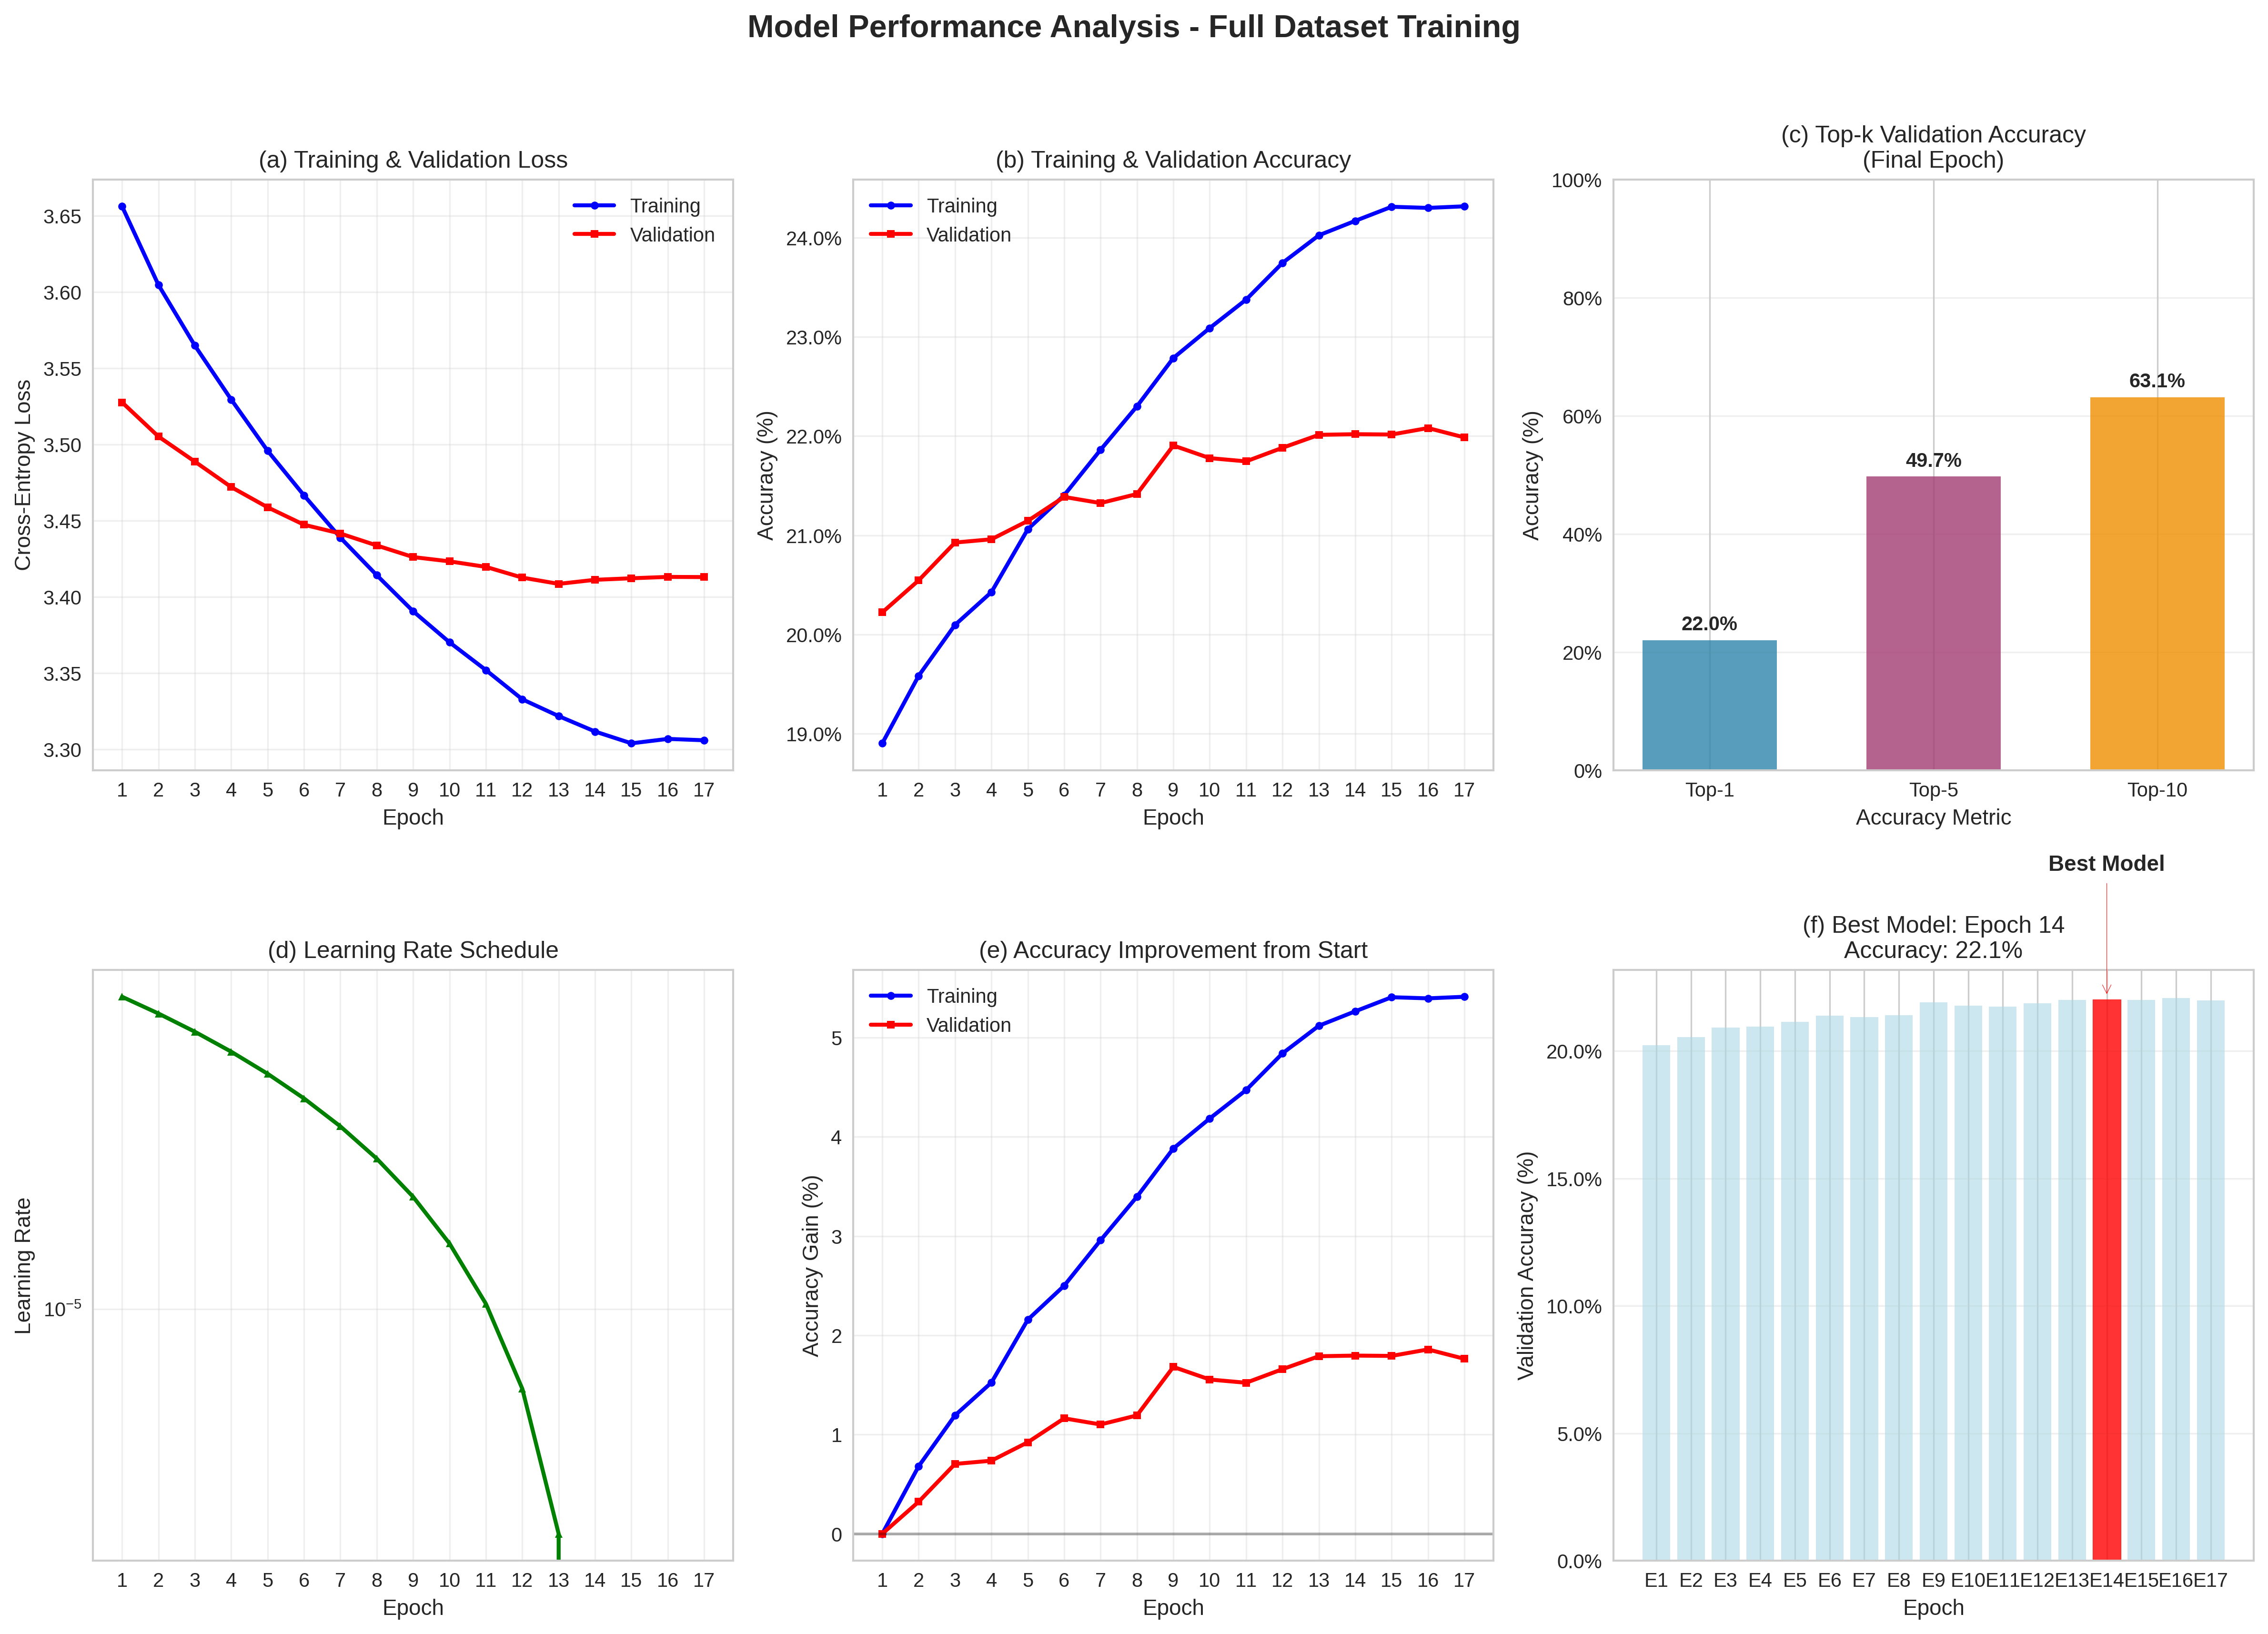


COMPREHENSIVE PERFORMANCE REPORT

📊 MODEL CONFIGURATION AND PERFORMANCE:
------------------------------------------------------------------------------------------
                   Metric        Value
             Dataset Size      204,583
        Number of Classes          195
               Batch Size           64
            Learning Rate      5.0e-05
          Training Epochs           15
      Total Training Time 71.6 minutes
 Best Validation Accuracy       22.08%
               Best Epoch           14
Final Validation Accuracy       21.99%
  Final Training Accuracy       24.31%
     Final Top-5 Accuracy       49.70%
    Final Top-10 Accuracy       63.11%
         Training Samples      173,895
       Validation Samples       30,688
Singleton Classes Removed            4
------------------------------------------------------------------------------------------

📈 PERFORMANCE IMPROVEMENT FROM PRE-TRAINED MODEL:
---------------------------------------------------------------------

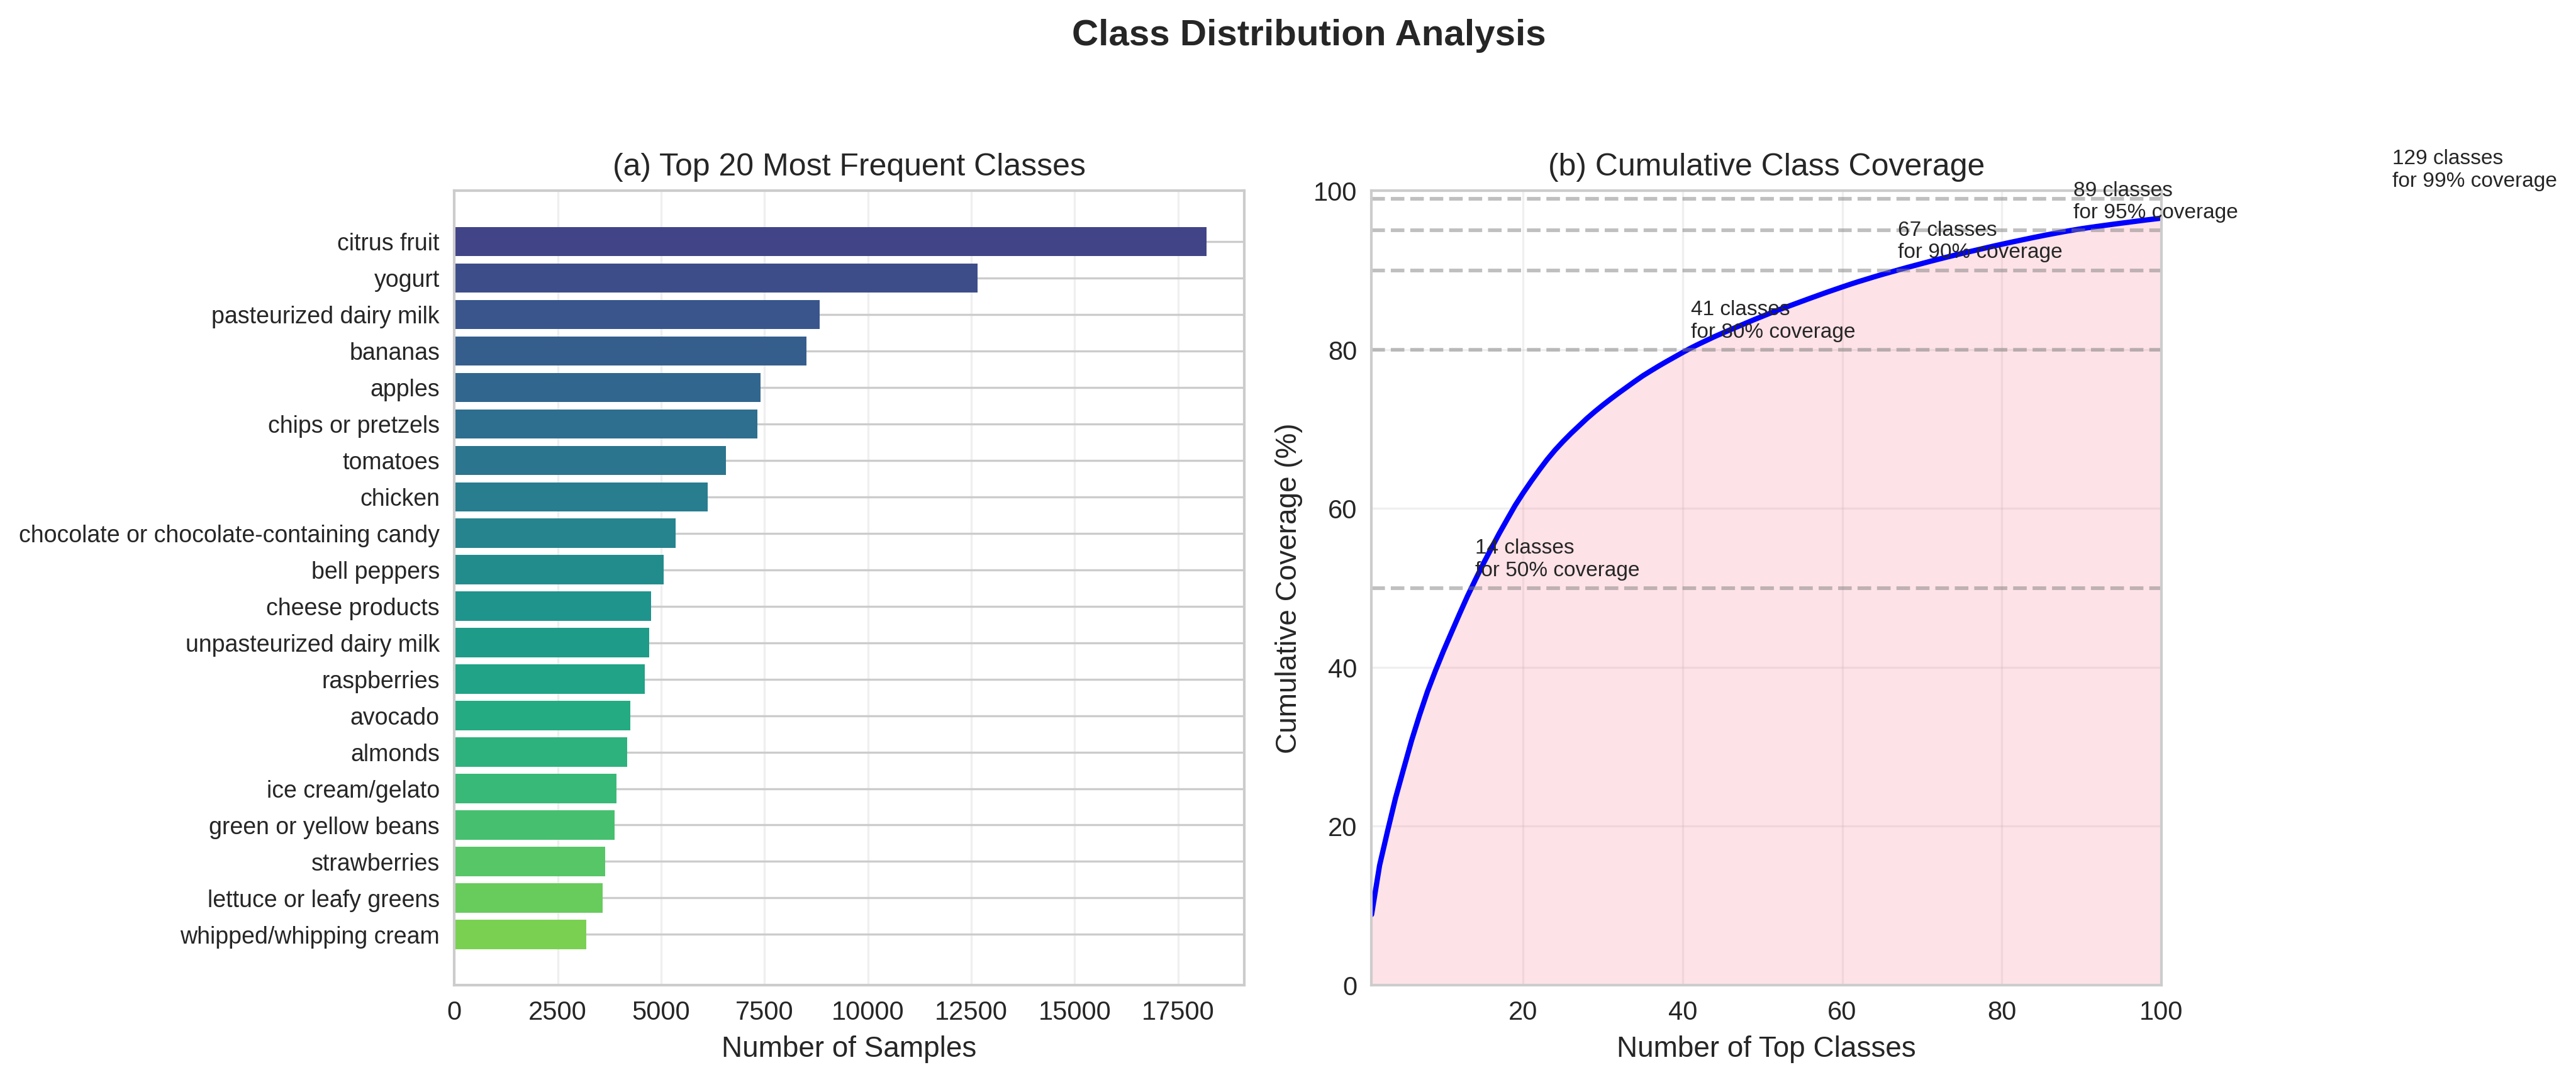


Class Coverage Statistics:
------------------------------------------------------------
 50% of samples covered by  14 classes (7.7% of all classes)
 80% of samples covered by  41 classes (22.5% of all classes)
 90% of samples covered by  67 classes (36.8% of all classes)
 95% of samples covered by  89 classes (48.9% of all classes)
 99% of samples covered by 129 classes (70.9% of all classes)

Total unique classes: 182
Most frequent class: citrus fruit (18184 samples)
Least frequent class: beef shawarma/donair (2 samples)
Average samples per class: 1124.1
Median samples per class: 296.0
------------------------------------------------------------

✓ All visualizations and reports generated successfully!
✓ Check the './full_dataset_models' directory for saved files


In [17]:
"""
Generate comprehensive outputs for research paper
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter

# Set style for research paper
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

print("\n" + "="*80)
print("GENERATING PROFESSIONAL VISUALIZATIONS AND REPORTS")
print("="*80)

# Create comprehensive performance dashboard
fig = plt.figure(figsize=(16, 12))
fig.suptitle('Model Performance Analysis - Full Dataset Training', 
             fontsize=16, fontweight='bold', y=0.98)

# 1. Loss curves
ax1 = plt.subplot(2, 3, 1)
epochs = range(1, len(metrics['train_loss']) + 1)
ax1.plot(epochs, metrics['train_loss'], 'b-', linewidth=2, label='Training', marker='o', markersize=4)
ax1.plot(epochs, metrics['val_loss'], 'r-', linewidth=2, label='Validation', marker='s', markersize=4)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.set_title('(a) Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs)

# 2. Accuracy curves
ax2 = plt.subplot(2, 3, 2)
ax2.plot(epochs, metrics['train_acc'], 'b-', linewidth=2, label='Training', marker='o', markersize=4)
ax2.plot(epochs, metrics['val_acc'], 'r-', linewidth=2, label='Validation', marker='s', markersize=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('(b) Training & Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_xticks(epochs)

# 3. Top-k accuracy comparison (final epoch)
ax3 = plt.subplot(2, 3, 3)
top_k_metrics = ['Top-1', 'Top-5', 'Top-10']
top_k_values = [metrics['val_acc'][-1], metrics['val_top5_acc'][-1], metrics['val_top10_acc'][-1]]
colors = ['#2E86AB', '#A23B72', '#F18F01']

bars = ax3.bar(top_k_metrics, top_k_values, color=colors, alpha=0.8, width=0.6)
ax3.set_xlabel('Accuracy Metric')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('(c) Top-k Validation Accuracy\n(Final Epoch)')
ax3.grid(True, alpha=0.3, axis='y')
ax3.yaxis.set_major_formatter(PercentFormatter())
ax3.set_ylim([0, 100])

# Add value labels
for bar, value in zip(bars, top_k_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Learning rate schedule
ax4 = plt.subplot(2, 3, 4)
ax4.plot(epochs, metrics['learning_rates'], 'g-', linewidth=2, marker='^', markersize=4)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.set_title('(d) Learning Rate Schedule')
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')
ax4.set_xticks(epochs)

# 5. Accuracy progression
ax5 = plt.subplot(2, 3, 5)
train_acc_gain = [acc - metrics['train_acc'][0] for acc in metrics['train_acc']]
val_acc_gain = [acc - metrics['val_acc'][0] for acc in metrics['val_acc']]

ax5.plot(epochs, train_acc_gain, 'b-', linewidth=2, label='Training', marker='o', markersize=4)
ax5.plot(epochs, val_acc_gain, 'r-', linewidth=2, label='Validation', marker='s', markersize=4)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Accuracy Gain (%)')
ax5.set_title('(e) Accuracy Improvement from Start')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_xticks(epochs)
ax5.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# 6. Best epoch highlight
ax6 = plt.subplot(2, 3, 6)
best_epoch_index = best_epoch - 1  # Convert to 0-index

epoch_labels = [f'E{i+1}' for i in range(len(epochs))]
val_acc_values = metrics['val_acc']

# Create bar plot
bars = ax6.bar(epoch_labels, val_acc_values, alpha=0.6, color='lightblue')
if best_epoch_index < len(bars):
    bars[best_epoch_index].set_color('red')
    bars[best_epoch_index].set_alpha(0.8)

ax6.set_xlabel('Epoch')
ax6.set_ylabel('Validation Accuracy (%)')
ax6.set_title(f'(f) Best Model: Epoch {best_epoch}\nAccuracy: {best_val_acc:.1f}%')
ax6.grid(True, alpha=0.3, axis='y')
ax6.yaxis.set_major_formatter(PercentFormatter())

# Add best epoch annotation if within range
if best_epoch_index < len(bars):
    ax6.annotate('Best Model', 
                 xy=(best_epoch_index, best_val_acc), 
                 xytext=(best_epoch_index, best_val_acc + 5),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 fontweight='bold',
                 ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Save figure
fig_path = os.path.join(TrainingConfig.SAVE_DIR, 'comprehensive_performance_dashboard.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Comprehensive performance dashboard saved to: {fig_path}")
plt.show()

# Create detailed performance table
print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE REPORT")
print("="*80)

# Performance metrics table
performance_data = {
    'Metric': [
        'Dataset Size', 'Number of Classes', 'Batch Size',
        'Learning Rate', 'Training Epochs', 'Total Training Time',
        'Best Validation Accuracy', 'Best Epoch',
        'Final Validation Accuracy', 'Final Training Accuracy',
        'Final Top-5 Accuracy', 'Final Top-10 Accuracy',
        'Training Samples', 'Validation Samples',
        'Singleton Classes Removed'
    ],
    'Value': [
        f"{len(full_data['all_sequences']):,}", 
        f"{len(label_encoder.classes_):,}",
        TrainingConfig.BATCH_SIZE,
        f"{TrainingConfig.LEARNING_RATE:.1e}",
        TrainingConfig.NUM_EPOCHS,
        f"{total_time/60:.1f} minutes",
        f"{best_val_acc:.2f}%",
        best_epoch,
        f"{val_acc:.2f}%",
        f"{train_acc:.2f}%",
        f"{top5_acc:.2f}%",
        f"{top10_acc:.2f}%",
        f"{len(train_sequences):,}",
        f"{len(val_sequences):,}",
        f"{full_data.get('num_singleton_classes', 0)}"
    ]
}

performance_df = pd.DataFrame(performance_data)
print("\n📊 MODEL CONFIGURATION AND PERFORMANCE:")
print("-" * 90)
print(performance_df.to_string(index=False))
print("-" * 90)

# Calculate improvements from pre-trained model
print(f"\n📈 PERFORMANCE IMPROVEMENT FROM PRE-TRAINED MODEL:")
print("-" * 90)

# Load original checkpoint to get pre-trained metrics
try:
    original_checkpoint = torch.load(pretrained_path, map_location=device, weights_only=False)
    
    if 'val_accuracy' in original_checkpoint:
        pretrained_acc = original_checkpoint['val_accuracy']
        
        # Get top-k accuracies if available
        pretrained_top5 = original_checkpoint.get('val_top5_accuracy', None)
        pretrained_top10 = original_checkpoint.get('val_top10_accuracy', None)
        
        improvement_data = {
            'Metric': ['Validation Accuracy'],
            'Pre-trained': [f"{pretrained_acc:.2f}%"],
            'Fine-tuned': [f"{best_val_acc:.2f}%"],
            'Absolute Δ': [f"{best_val_acc - pretrained_acc:+.2f}%"],
            'Relative Gain': [f"{((best_val_acc/pretrained_acc)-1)*100:+.1f}%"]
        }
        
        # Add top-k if available
        if pretrained_top5 is not None:
            improvement_data['Metric'].append('Top-5 Accuracy')
            improvement_data['Pre-trained'].append(f"{pretrained_top5:.2f}%")
            improvement_data['Fine-tuned'].append(f"{top5_acc:.2f}%")
            improvement_data['Absolute Δ'].append(f"{top5_acc - pretrained_top5:+.2f}%")
            improvement_data['Relative Gain'].append(f"{((top5_acc/pretrained_top5)-1)*100:+.1f}%")
        
        if pretrained_top10 is not None:
            improvement_data['Metric'].append('Top-10 Accuracy')
            improvement_data['Pre-trained'].append(f"{pretrained_top10:.2f}%")
            improvement_data['Fine-tuned'].append(f"{top10_acc:.2f}%")
            improvement_data['Absolute Δ'].append(f"{top10_acc - pretrained_top10:+.2f}%")
            improvement_data['Relative Gain'].append(f"{((top10_acc/pretrained_top10)-1)*100:+.1f}%")
        
        improvement_df = pd.DataFrame(improvement_data)
        print(improvement_df.to_string(index=False))
    else:
        print("Pre-trained model validation metrics not available for comparison")
except Exception as e:
    print(f"Could not load pre-trained model for comparison: {e}")

print("-" * 90)

# Create convergence analysis
print(f"\n📊 CONVERGENCE ANALYSIS:")
print("-" * 90)

convergence_data = {
    'Phase': ['Initial (Epoch 1)', 'Best (Final)', 'Improvement'],
    'Training Loss': [f"{metrics['train_loss'][0]:.4f}", f"{metrics['train_loss'][-1]:.4f}", 
                      f"{(metrics['train_loss'][0] - metrics['train_loss'][-1])/metrics['train_loss'][0]*100:.1f}% reduction"],
    'Validation Loss': [f"{metrics['val_loss'][0]:.4f}", f"{metrics['val_loss'][-1]:.4f}", 
                        f"{(metrics['val_loss'][0] - metrics['val_loss'][-1])/metrics['val_loss'][0]*100:.1f}% reduction"],
    'Training Acc': [f"{metrics['train_acc'][0]:.2f}%", f"{metrics['train_acc'][-1]:.2f}%", 
                     f"+{metrics['train_acc'][-1] - metrics['train_acc'][0]:.2f}%"],
    'Validation Acc': [f"{metrics['val_acc'][0]:.2f}%", f"{metrics['val_acc'][-1]:.2f}%", 
                       f"+{metrics['val_acc'][-1] - metrics['val_acc'][0]:.2f}%"]
}

convergence_df = pd.DataFrame(convergence_data)
print(convergence_df.to_string(index=False))
print("-" * 90)

# Create class distribution visualization
print(f"\n📈 CLASS DISTRIBUTION ANALYSIS:")

# Get class frequencies
all_labels_array = np.array(full_data['all_labels'])
unique_classes, class_counts = np.unique(all_labels_array, return_counts=True)

# Sort by frequency
sorted_indices = np.argsort(class_counts)[::-1]
sorted_classes = unique_classes[sorted_indices]
sorted_counts = class_counts[sorted_indices]

# Create class distribution plot
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig2.suptitle('Class Distribution Analysis', fontsize=14, fontweight='bold')

# Bar chart of top 20 classes
top_n = min(20, len(sorted_classes))
class_names_top = [label_encoder.inverse_transform([cls])[0] for cls in sorted_classes[:top_n]]

bars = ax1.barh(range(top_n), sorted_counts[:top_n], color=plt.cm.viridis(np.linspace(0.2, 0.8, top_n)))
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(class_names_top, fontsize=9)
ax1.set_xlabel('Number of Samples')
ax1.set_title(f'(a) Top {top_n} Most Frequent Classes')
ax1.invert_yaxis()  # Highest at top
ax1.grid(True, alpha=0.3, axis='x')

# Cumulative distribution
cumulative_percentage = np.cumsum(sorted_counts) / np.sum(sorted_counts) * 100
num_classes_to_cover = [50, 80, 90, 95, 99]
coverage_info = []

for coverage in num_classes_to_cover:
    idx = np.argmax(cumulative_percentage >= coverage)
    coverage_info.append((coverage, idx + 1, sorted_counts[idx]))

x_range = np.arange(1, len(cumulative_percentage) + 1)
ax2.plot(x_range, cumulative_percentage, 'b-', linewidth=2)
ax2.fill_between(x_range, 0, cumulative_percentage, alpha=0.2)
ax2.set_xlabel('Number of Top Classes')
ax2.set_ylabel('Cumulative Coverage (%)')
ax2.set_title('(b) Cumulative Class Coverage')
ax2.grid(True, alpha=0.3)

# Add coverage annotations
for coverage, n_classes, count in coverage_info:
    ax2.axhline(y=coverage, color='gray', linestyle='--', alpha=0.5)
    ax2.text(n_classes, coverage + 1, f'{n_classes} classes\nfor {coverage}% coverage',
            fontsize=8, ha='left', va='bottom')

ax2.set_xlim([1, min(100, len(cumulative_percentage))])
ax2.set_ylim([0, 100])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig2_path = os.path.join(TrainingConfig.SAVE_DIR, 'class_distribution_analysis.png')
plt.savefig(fig2_path, dpi=300, bbox_inches='tight')
print(f"✓ Class distribution analysis saved to: {fig2_path}")
plt.show()

# Print coverage statistics
print(f"\nClass Coverage Statistics:")
print("-" * 60)
for coverage, n_classes, count in coverage_info:
    percentage_of_classes = n_classes / len(unique_classes) * 100
    print(f"{coverage:>3}% of samples covered by {n_classes:>3} classes ({percentage_of_classes:.1f}% of all classes)")

print(f"\nTotal unique classes: {len(unique_classes)}")
print(f"Most frequent class: {class_names_top[0]} ({sorted_counts[0]} samples)")
print(f"Least frequent class: {label_encoder.inverse_transform([sorted_classes[-1]])[0]} ({sorted_counts[-1]} samples)")
print(f"Average samples per class: {np.mean(class_counts):.1f}")
print(f"Median samples per class: {np.median(class_counts):.1f}")
print("-" * 60)

print(f"\n✓ All visualizations and reports generated successfully!")
print(f"✓ Check the '{TrainingConfig.SAVE_DIR}' directory for saved files")


DETAILED PREDICTION ANALYSIS

🔍 Loading best model from epoch 14...
Model is DataParallel but checkpoint doesn't have 'module.' prefix
Adding 'module.' prefix to checkpoint keys...
✓ Model loaded successfully

📋 ANALYSIS OF 5 RANDOM VALIDATION EXAMPLES:

EXAMPLE 1:
------------------------------------------------------------------------------------------------------------------------
📦 PURCHASE HISTORY:
   Order 1: apples | apples | pasteurized dairy milk [SEP] Order 2: apples | pasteurized dairy milk | a...

🎯 TRUE NEXT ITEM: pasteurized dairy milk
🤖 MODEL PREDICTION: pasteurized dairy milk (88.8% confidence)
✅ CORRECT! True item is rank #1 in top 10 predictions

📊 TOP 5 PREDICTIONS:
    1. pasteurized dairy milk                          88.8% ✓
    2. apples                                           5.5%
    3. citrus fruit                                     0.8%
    4. nectarines                                       0.5%
    5. chips or pretzels                                0.4

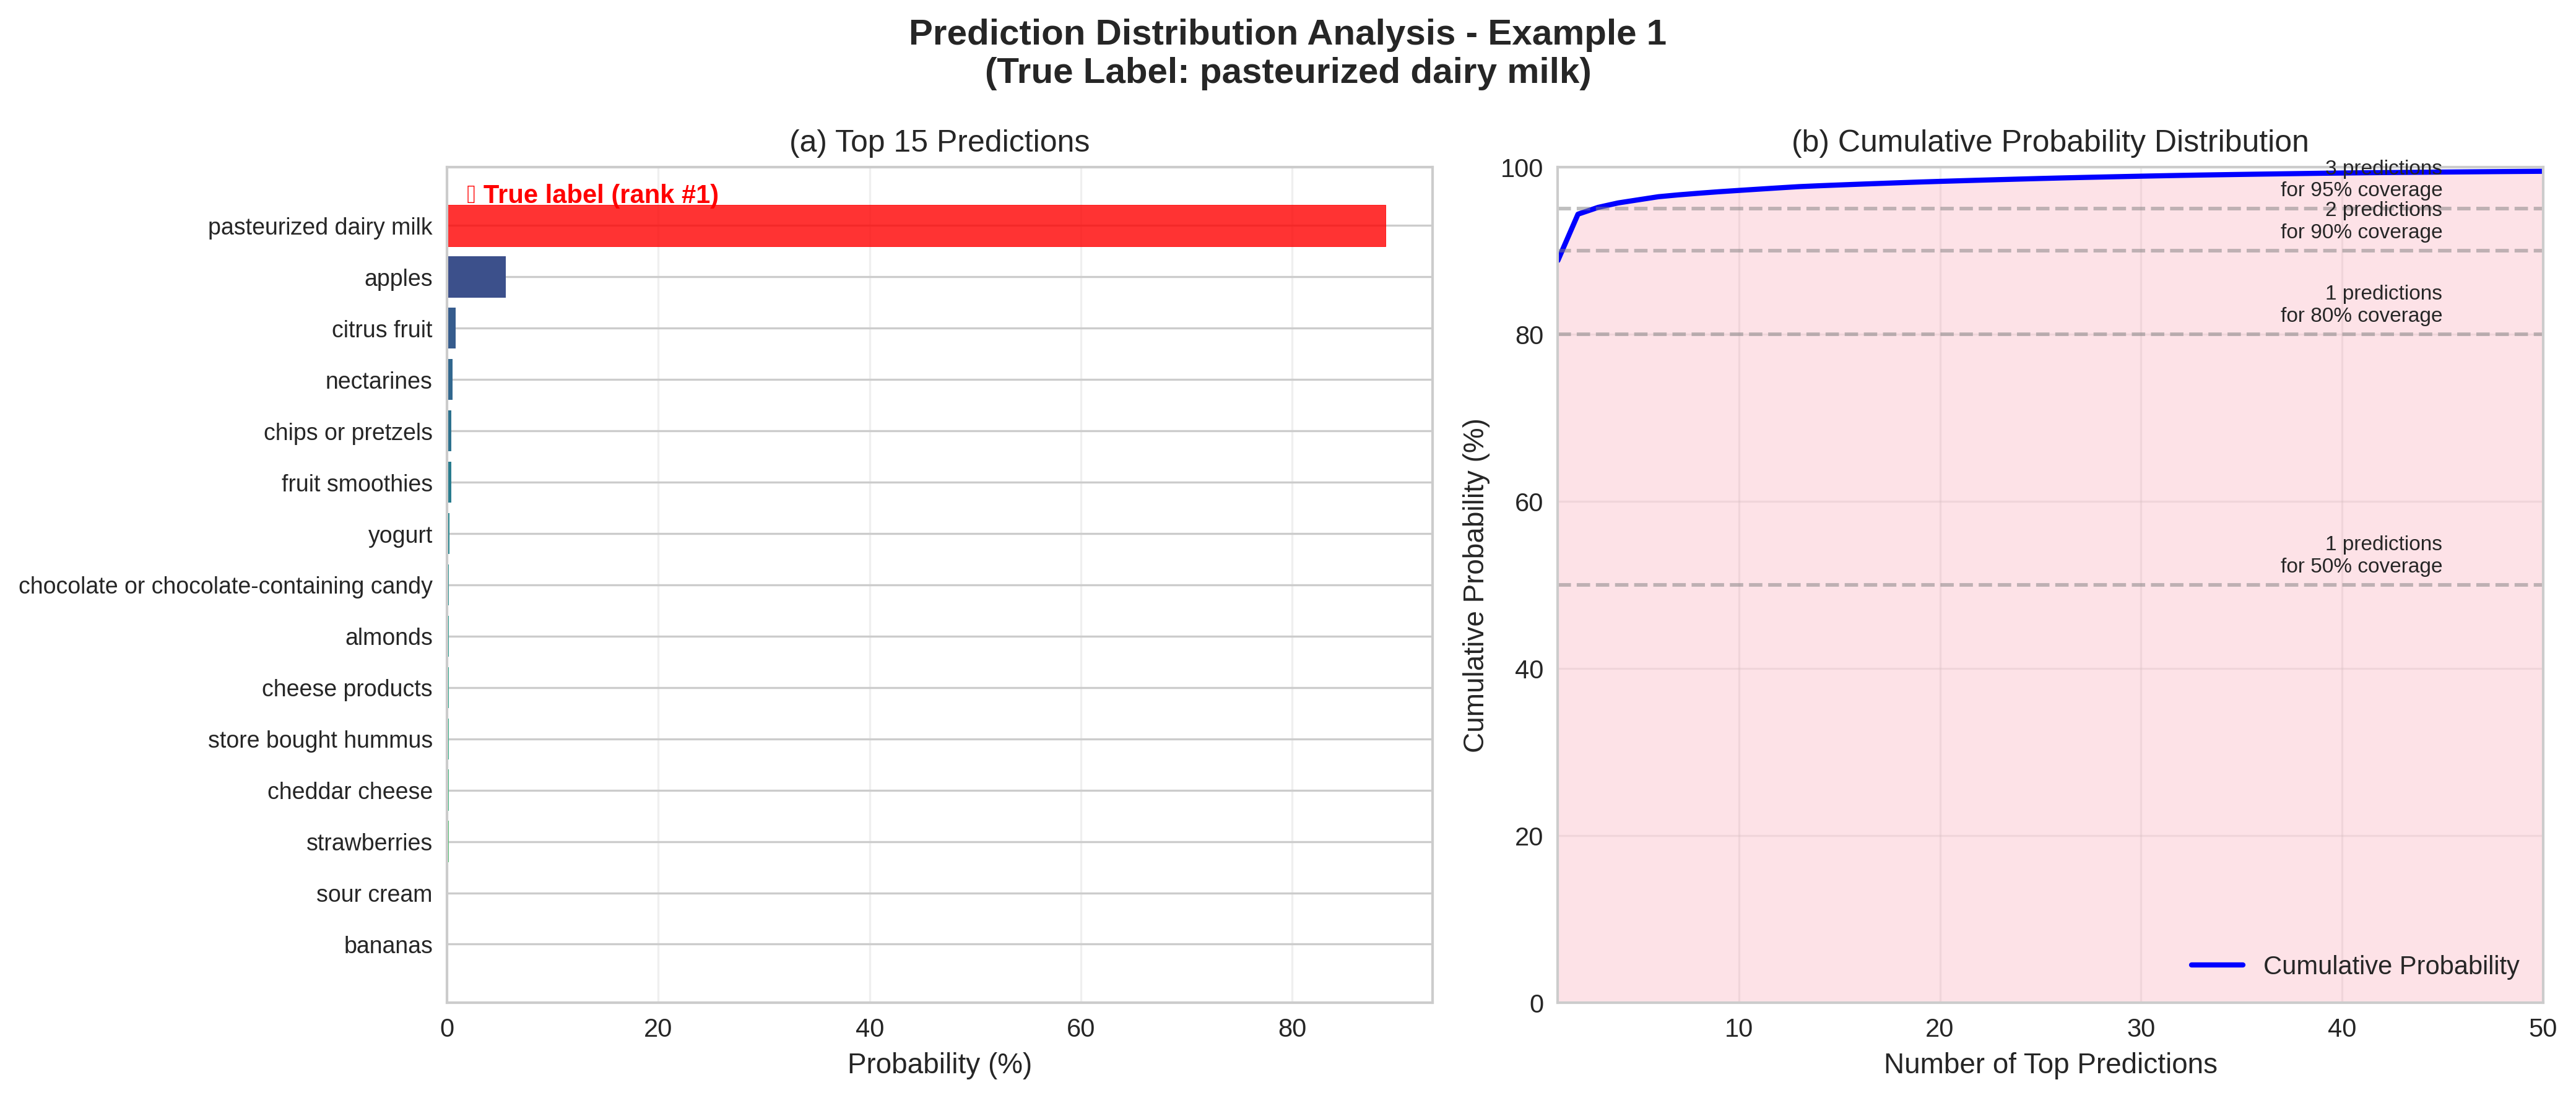


SUMMARY OF ALL ANALYZED EXAMPLES

 Example                                True Label         Top Prediction Top Confidence Correct True Rank in Top10
       1                    pasteurized dairy milk pasteurized dairy milk          88.8%     Yes                  1
       2 granola bars, power bars, or protein bars           citrus fruit           9.7%      No                N/A
       3                                    apples          peanut butter          57.4%     Yes                  3
       4                                 cucumbers              cucumbers          69.1%     Yes                  1
       5                                   avocado                avocado          43.9%     Yes                  1

📊 SUMMARY STATISTICS:
--------------------------------------------------
Top-1 Accuracy: 3/5 (60.0%)
Top-10 Accuracy: 4/5 (80.0%)
Average Top Prediction Confidence: 53.8%
Examples with True Label in Top-5: 4/5

ANALYSIS COMPLETE

✓ All prediction analyses completed su

In [21]:
"""
Generate detailed prediction analysis with readable outputs
"""

print("\n" + "="*80)
print("DETAILED PREDICTION ANALYSIS")
print("="*80)

# Load the best model for predictions
print(f"\n🔍 Loading best model from epoch {best_epoch}...")
best_checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)

# Check if model was saved with DataParallel
state_dict = best_checkpoint['model_state_dict']
has_module_prefix = any(k.startswith('module.') for k in state_dict.keys())

# Handle DataParallel prefix
if isinstance(model, nn.DataParallel) and not has_module_prefix:
    print("Model is DataParallel but checkpoint doesn't have 'module.' prefix")
    print("Adding 'module.' prefix to checkpoint keys...")
    # Add 'module.' prefix to all keys
    state_dict = {'module.' + k: v for k, v in state_dict.items()}
elif not isinstance(model, nn.DataParallel) and has_module_prefix:
    print("Model is not DataParallel but checkpoint has 'module.' prefix")
    print("Removing 'module.' prefix from checkpoint keys...")
    # Remove 'module.' prefix from all keys
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

# Load the state dict
model.load_state_dict(state_dict)
model.eval()

print(f"✓ Model loaded successfully")

# Select diverse examples for analysis
np.random.seed(42)
num_examples = 5
example_indices = np.random.choice(len(val_sequences), num_examples, replace=False)

print(f"\n📋 ANALYSIS OF {num_examples} RANDOM VALIDATION EXAMPLES:")
print("="*120)

all_examples_data = []

for i, idx in enumerate(example_indices, 1):
    sequence = val_sequences[idx]
    true_label_idx = val_labels[idx]
    true_label = label_encoder.inverse_transform([true_label_idx])[0]
    
    # Tokenize
    encoding = tokenizer(
        sequence,
        truncation=True,
        padding='max_length',
        max_length=TrainingConfig.MAX_SEQUENCE_LENGTH,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probabilities, 10)
    
    # Get top prediction
    top_pred_idx = top_indices[0][0].item()
    top_pred = label_encoder.inverse_transform([top_pred_idx])[0]
    top_confidence = top_probs[0][0].item() * 100
    
    # Check if true label is in top predictions
    true_in_top10 = any(true_label_idx == idx.item() for idx in top_indices[0])
    true_rank = None
    if true_in_top10:
        true_rank = (top_indices[0] == true_label_idx).nonzero().item() + 1
    
    # Store example data for later use
    example_data = {
        'example_num': i,
        'sequence': sequence,
        'true_label': true_label,
        'top_pred': top_pred,
        'top_confidence': top_confidence,
        'true_in_top10': true_in_top10,
        'true_rank': true_rank,
        'top_probs': top_probs[0].cpu().numpy(),
        'top_indices': top_indices[0].cpu().numpy(),
        'all_probabilities': probabilities[0].cpu().numpy()
    }
    all_examples_data.append(example_data)
    
    print(f"\nEXAMPLE {i}:")
    print(f"{'-'*120}")
    
    # Display input sequence (truncated)
    seq_preview = sequence[:100] + "..." if len(sequence) > 100 else sequence
    print(f"📦 PURCHASE HISTORY:")
    print(f"   {seq_preview}")
    
    print(f"\n🎯 TRUE NEXT ITEM: {true_label}")
    print(f"🤖 MODEL PREDICTION: {top_pred} ({top_confidence:.1f}% confidence)")
    
    if true_in_top10:
        print(f"✅ CORRECT! True item is rank #{true_rank} in top 10 predictions")
    else:
        print(f"❌ INCORRECT - True item not in top 10 predictions")
    
    print(f"\n📊 TOP 5 PREDICTIONS:")
    for rank, (prob, idx) in enumerate(zip(top_probs[0][:5], top_indices[0][:5]), 1):
        item = label_encoder.inverse_transform([idx.item()])[0]
        prob_pct = prob.item() * 100
        indicator = " ✓" if idx.item() == true_label_idx else ""
        print(f"   {rank:2}. {item:<45} {prob_pct:>6.1f}%{indicator}")
    
    print(f"{'-'*120}")

# Detailed analysis for first example
print(f"\n{'='*80}")
print("COMPREHENSIVE ANALYSIS - EXAMPLE 1")
print(f"{'='*80}")

idx = example_indices[0]
sequence = val_sequences[idx]
true_label_idx = val_labels[idx]
true_label = label_encoder.inverse_transform([true_label_idx])[0]

print(f"\n📋 FULL INPUT SEQUENCE:")
print(f"{'-'*80}")
print(sequence)
print(f"{'-'*80}")

print(f"\n🎯 GROUND TRUTH: {true_label}")

# Get all predictions for this example
encoding = tokenizer(
    sequence,
    truncation=True,
    padding='max_length',
    max_length=TrainingConfig.MAX_SEQUENCE_LENGTH,
    return_tensors='pt'
)

input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    probabilities = torch.softmax(outputs, dim=1)[0]

# Get top 15 predictions
top_probs, top_indices = torch.topk(probabilities, 15)

print(f"\n📊 TOP 10 PREDICTIONS WITH CONFIDENCE SCORES:")
print(f"{'-'*75}")
print(f"{'Rank':^6} {'Predicted Item':^40} {'Probability':^12} {'Cumulative':^12}")
print(f"{'-'*75}")

cumulative_prob = 0
for rank, (prob, idx) in enumerate(zip(top_probs[:10], top_indices[:10]), 1):
    item = label_encoder.inverse_transform([idx.item()])[0]
    prob_pct = prob.item() * 100
    cumulative_prob += prob_pct
    star = " ★" if idx.item() == true_label_idx else ""
    print(f"{rank:^6} {item:<40}{star:^2} {prob_pct:>10.2f}% {cumulative_prob:>10.2f}%")

print(f"{'-'*75}")
print(f"Total probability covered by top 10: {cumulative_prob:.2f}%")

# Find true label probability
true_prob = probabilities[true_label_idx].item() * 100
true_rank_list = (top_indices == true_label_idx).nonzero()
if true_rank_list.numel() > 0:
    true_rank = true_rank_list.item() + 1
    print(f"\n📈 TRUE LABEL STATISTICS:")
    print(f"   • Rank: #{true_rank}")
    print(f"   • Probability: {true_prob:.2f}%")
    print(f"   • Confidence relative to top: {(true_prob/top_probs[0].item()*100):.1f}%")
else:
    print(f"\n⚠️  True label not in top 15 predictions")
    print(f"   • Probability: {true_prob:.4f}%")

# Get all non-zero probabilities (> 0.001%)
print(f"\n📈 ALL SIGNIFICANT PREDICTIONS (> 0.001% probability):")
print(f"{'-'*70}")

threshold = 0.001  # 0.001%
non_zero_mask = probabilities > (threshold / 100)
non_zero_indices = torch.where(non_zero_mask)[0]
non_zero_probs = probabilities[non_zero_indices]

if len(non_zero_indices) > 0:
    # Sort by probability
    sorted_probs, sorted_idx = torch.sort(non_zero_probs, descending=True)
    sorted_indices = non_zero_indices[sorted_idx]
    
    print(f"Found {len(non_zero_indices)} items with probability > {threshold}%")
    print(f"\nTop 20 significant predictions:")
    print(f"{'-'*70}")
    
    for i, (prob, idx) in enumerate(zip(sorted_probs[:20], sorted_indices[:20]), 1):
        item = label_encoder.inverse_transform([idx.item()])[0]
        prob_pct = prob.item() * 100
        marker = " →" if idx.item() == true_label_idx else ""
        print(f"{i:3}. {item:<45}{marker:^2} {prob_pct:>8.3f}%")
    
    if len(non_zero_indices) > 20:
        min_prob_shown = sorted_probs[19].item() * 100
        print(f"... and {len(non_zero_indices) - 20} more items with probabilities < {min_prob_shown:.3f}%")
    
    # Statistics
    total_prob_covered = sorted_probs.sum().item() * 100
    print(f"\n📊 STATISTICS:")
    print(f"   • Total probability mass > {threshold}%: {total_prob_covered:.2f}%")
    print(f"   • Number of items considered: {len(non_zero_indices)}")
    print(f"   • Average probability per item: {total_prob_covered/len(non_zero_indices):.3f}%")
    if true_label_idx in sorted_indices:
        true_idx = (sorted_indices == true_label_idx).nonzero().item()
        print(f"   • True label rank among significant items: {true_idx + 1}")
    else:
        print(f"   • True label not in significant items")
else:
    print("No predictions exceed the 0.001% threshold")

print(f"{'='*80}")

# Create prediction distribution visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Prediction Distribution Analysis - Example 1\n(True Label: {true_label})', 
             fontsize=14, fontweight='bold')

# Bar chart of top 15 predictions
top15_items = [label_encoder.inverse_transform([idx.item()])[0] for idx in top_indices[:15]]
top15_probs = [prob.item() * 100 for prob in top_probs[:15]]

x_pos = np.arange(len(top15_items))
bars = ax1.barh(x_pos, top15_probs, color=plt.cm.viridis(np.linspace(0.2, 0.8, 15)))
ax1.set_yticks(x_pos)
ax1.set_yticklabels(top15_items, fontsize=9)
ax1.set_xlabel('Probability (%)')
ax1.set_title('(a) Top 15 Predictions')
ax1.invert_yaxis()  # Highest at top
ax1.grid(True, alpha=0.3, axis='x')

# Highlight true label
true_in_top15 = any(true_label_idx == idx.item() for idx in top_indices[:15])
if true_in_top15:
    true_idx_in_top15 = (top_indices[:15] == true_label_idx).nonzero().item()
    bars[true_idx_in_top15].set_color('red')
    bars[true_idx_in_top15].set_alpha(0.8)
    ax1.text(0.02, 0.98, f'✓ True label (rank #{true_rank})', 
             transform=ax1.transAxes, fontsize=10, fontweight='bold',
             verticalalignment='top', color='red')

# Probability distribution curve
sorted_all_probs, _ = torch.sort(probabilities, descending=True)
cumulative_probs = torch.cumsum(sorted_all_probs, dim=0) * 100
x_range = np.arange(1, min(50, len(cumulative_probs)) + 1)

ax2.plot(x_range, cumulative_probs[:50].cpu().numpy(), 'b-', linewidth=2)
ax2.fill_between(x_range, 0, cumulative_probs[:50].cpu().numpy(), alpha=0.2)
ax2.set_xlabel('Number of Top Predictions')
ax2.set_ylabel('Cumulative Probability (%)')
ax2.set_title('(b) Cumulative Probability Distribution')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([1, 50])
ax2.set_ylim([0, 100])

# Add reference lines
coverage_levels = [50, 80, 90, 95]
for coverage in coverage_levels:
    # Find how many predictions needed for this coverage
    idx = (cumulative_probs >= coverage).nonzero()
    if idx.numel() > 0:
        n_predictions = idx[0].item() + 1
        ax2.axhline(y=coverage, color='gray', linestyle='--', alpha=0.5)
        ax2.text(45, coverage+1, f'{n_predictions} predictions\nfor {coverage}% coverage',
                fontsize=8, ha='right', va='bottom')

ax2.legend(['Cumulative Probability'], loc='lower right')

plt.tight_layout()
fig_path = os.path.join(TrainingConfig.SAVE_DIR, 'detailed_prediction_analysis.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Detailed prediction analysis plot saved to: {fig_path}")
plt.show()

# Create summary of all examples
print(f"\n{'='*80}")
print("SUMMARY OF ALL ANALYZED EXAMPLES")
print(f"{'='*80}")

summary_data = []
for example in all_examples_data:
    summary_data.append({
        'Example': example['example_num'],
        'True Label': example['true_label'],
        'Top Prediction': example['top_pred'],
        'Top Confidence': f"{example['top_confidence']:.1f}%",
        'Correct': 'Yes' if example['true_in_top10'] else 'No',
        'True Rank in Top10': example['true_rank'] if example['true_rank'] else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Calculate statistics
correct_predictions = sum(1 for example in all_examples_data if example['true_in_top10'])
top1_correct = sum(1 for example in all_examples_data if example['true_label'] == example['top_pred'])
avg_confidence = np.mean([example['top_confidence'] for example in all_examples_data])

print(f"\n📊 SUMMARY STATISTICS:")
print(f"{'-'*50}")
print(f"Top-1 Accuracy: {top1_correct}/{num_examples} ({top1_correct/num_examples*100:.1f}%)")
print(f"Top-10 Accuracy: {correct_predictions}/{num_examples} ({correct_predictions/num_examples*100:.1f}%)")
print(f"Average Top Prediction Confidence: {avg_confidence:.1f}%")
print(f"Examples with True Label in Top-5: {sum(1 for example in all_examples_data if example.get('true_rank') is not None and example['true_rank'] <= 5)}/{num_examples}")
print(f"\n{'='*80}")
print("ANALYSIS COMPLETE")
print(f"{'='*80}")
print(f"\n✓ All prediction analyses completed successfully!")
print(f"✓ Check '{TrainingConfig.SAVE_DIR}' directory for saved visualizations")
print(f"✓ Best model saved at: {best_model_path}")
print(f"✓ Training completed in {total_time/60:.1f} minutes with {TrainingConfig.NUM_EPOCHS} epochs")
print(f"✓ Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")

In [26]:
# ==================================================
# BLOCK 1: SETUP AND CONFIGURATION
# ==================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')
import os

print("="*80)
print("FAST FOOD CATEGORY PREDICTION SYSTEM")
print("="*80)

class FastFoodConfig:
    # Data paths
    BINARY_DATA_PATH = "/kaggle/input/foodbank-microdata1/corrected_foodbook_dataset.csv"
    PRETRAINED_MODEL_PATH = "./full_dataset_models/best_model_epoch_14.pth"
    
    # Features to exclude from model input
    EXCLUDE_FEATURES = [
        'asian_style_foods', 'indian_style_foods', 'mexican_style_foods',
        'had_fastfood', 'burger_fastfood', 'submarine_sandwich_fastfood',
        'fried_chicken_fastfood', 'mexican_fastfood', 'pizza_fastfood',
        'hot_dog_fastfood', 'other_fastfood', 'fastfood_freq_AQ110',
        'fastfood_freq_AQ111', 'ate_out_broad', 'food_type_simple',
        'restaurant_food'
    ]
    
    # Model parameters
    BATCH_SIZE = 32
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    
    # Save directories
    SAVE_DIR = "./fastfood_models"
    os.makedirs(SAVE_DIR, exist_ok=True)
    
    # Device
    USE_CUDA = torch.cuda.is_available()

FAST FOOD CATEGORY PREDICTION SYSTEM


In [27]:
# ==================================================
# BLOCK 2: LOAD AND PREPARE DATA (WITH FEATURE EXCLUSION)
# ==================================================

print("\n[BLOCK 2] Loading and preparing data with feature exclusion...")

# Load binary data
binary_data = pd.read_csv(FastFoodConfig.BINARY_DATA_PATH)

# Find target column
target_column = None
for col in binary_data.columns:
    if 'fast' in col.lower() and 'category' in col.lower():
        target_column = col
        break

if target_column is None:
    categorical_cols = binary_data.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        target_column = categorical_cols[0]
        print(f"Using {target_column} as target")
    else:
        raise ValueError("No target column found")

print(f"Target column: {target_column}")

# Get binary features, EXCLUDING the specified features
binary_feature_cols = []
for col in binary_data.columns:
    if col != target_column:
        # Skip excluded features
        if col in FastFoodConfig.EXCLUDE_FEATURES:
            continue
        
        unique_vals = binary_data[col].dropna().unique()
        if set(unique_vals).issubset({0, 1}) or set(unique_vals).issubset({0.0, 1.0}):
            binary_feature_cols.append(col)

print(f"Found {len(binary_feature_cols)} binary features (after exclusion)")
print(f"Excluded {len(FastFoodConfig.EXCLUDE_FEATURES)} features from model input")

# Show which features were excluded
excluded_in_data = [feat for feat in FastFoodConfig.EXCLUDE_FEATURES if feat in binary_data.columns]
print(f"Features excluded: {excluded_in_data}")

# Prepare binary features and target
X_binary = binary_data[binary_feature_cols].values.astype(np.float32)
y = binary_data[target_column].values

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"Feature matrix shape: {X_binary.shape}")


[BLOCK 2] Loading and preparing data with feature exclusion...
Target column: fastfood_category
Found 107 binary features (after exclusion)
Excluded 16 features from model input
Features excluded: ['asian_style_foods', 'indian_style_foods', 'mexican_style_foods', 'had_fastfood', 'burger_fastfood', 'submarine_sandwich_fastfood', 'fried_chicken_fastfood', 'mexican_fastfood', 'pizza_fastfood', 'hot_dog_fastfood', 'other_fastfood', 'fastfood_freq_AQ110', 'fastfood_freq_AQ111', 'ate_out_broad', 'food_type_simple', 'restaurant_food']

Number of classes: 12
Classes: ['asian' 'burger' 'fried_chicken' 'hot_dog' 'indian' 'mexican' 'multiple'
 'none' 'other' 'pizza' 'shawarma' 'submarine_sandwich']
Feature matrix shape: (3586, 107)


In [28]:
# ==================================================
# BLOCK 2: LOAD AND PREPARE DATA (WITH FEATURE EXCLUSION)
# ==================================================

print("\n[BLOCK 2] Loading and preparing data with feature exclusion...")

# Load binary data
binary_data = pd.read_csv(FastFoodConfig.BINARY_DATA_PATH)

# Find target column
target_column = None
for col in binary_data.columns:
    if 'fast' in col.lower() and 'category' in col.lower():
        target_column = col
        break

if target_column is None:
    categorical_cols = binary_data.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        target_column = categorical_cols[0]
        print(f"Using {target_column} as target")
    else:
        raise ValueError("No target column found")

print(f"Target column: {target_column}")

# Get binary features, EXCLUDING the specified features
binary_feature_cols = []
for col in binary_data.columns:
    if col != target_column:
        # Skip excluded features
        if col in FastFoodConfig.EXCLUDE_FEATURES:
            continue
        
        unique_vals = binary_data[col].dropna().unique()
        if set(unique_vals).issubset({0, 1}) or set(unique_vals).issubset({0.0, 1.0}):
            binary_feature_cols.append(col)

print(f"Found {len(binary_feature_cols)} binary features (after exclusion)")
print(f"Excluded {len(FastFoodConfig.EXCLUDE_FEATURES)} features from model input")

# Show which features were excluded
excluded_in_data = [feat for feat in FastFoodConfig.EXCLUDE_FEATURES if feat in binary_data.columns]
print(f"Features excluded: {excluded_in_data}")

# Prepare binary features and target
X_binary = binary_data[binary_feature_cols].values.astype(np.float32)
y = binary_data[target_column].values

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"Feature matrix shape: {X_binary.shape}")


[BLOCK 2] Loading and preparing data with feature exclusion...
Target column: fastfood_category
Found 107 binary features (after exclusion)
Excluded 16 features from model input
Features excluded: ['asian_style_foods', 'indian_style_foods', 'mexican_style_foods', 'had_fastfood', 'burger_fastfood', 'submarine_sandwich_fastfood', 'fried_chicken_fastfood', 'mexican_fastfood', 'pizza_fastfood', 'hot_dog_fastfood', 'other_fastfood', 'fastfood_freq_AQ110', 'fastfood_freq_AQ111', 'ate_out_broad', 'food_type_simple', 'restaurant_food']

Number of classes: 12
Classes: ['asian' 'burger' 'fried_chicken' 'hot_dog' 'indian' 'mexican' 'multiple'
 'none' 'other' 'pizza' 'shawarma' 'submarine_sandwich']
Feature matrix shape: (3586, 107)


In [29]:
# ==================================================
# BLOCK 3: CREATE BERT SEQUENCES FROM BINARY DATA
# ==================================================

print("\n[BLOCK 3] Creating BERT sequences...")

def create_bert_sequence(binary_features, feature_names):
    """Convert binary features to BERT sequence format"""
    items = []
    for i, val in enumerate(binary_features):
        if val == 1:
            item_name = feature_names[i].replace('_', ' ')
            items.append(item_name)
    
    if len(items) == 0:
        return "Order 1: no food items"
    
    # Format exactly like previous BERT training data
    return f"Order 1: {' | '.join(items[:50])}"  # Limit to 50 items max

# Create sequences for all samples
virtual_sequences = []
for i in range(len(X_binary)):
    seq = create_bert_sequence(X_binary[i], binary_feature_cols)
    virtual_sequences.append(seq)

print(f"Created {len(virtual_sequences)} virtual sequences")
print(f"Sample sequence: {virtual_sequences[0][:100]}...")


[BLOCK 3] Creating BERT sequences...
Created 3586 virtual sequences
Sample sequence: Order 1: fish | eggs...


In [31]:
# ==================================================
# BLOCK 4: LOAD PRE-TRAINED BERT AND EXTRACT FEATURES
# ==================================================

print("\n[BLOCK 4] Loading pre-trained BERT model...")

# Define model architecture (same as before)
class FoodCategoryClassifier(nn.Module):
    def __init__(self, model_name: str, num_classes: int):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Load model
device = torch.device('cuda' if FastFoodConfig.USE_CUDA else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-mini")
if tokenizer.sep_token is None:
    tokenizer.sep_token = '[SEP]'

pretrained_model = FoodCategoryClassifier("prajjwal1/bert-mini", 195).to(device)

# Load checkpoint
checkpoint = torch.load(FastFoodConfig.PRETRAINED_MODEL_PATH, map_location=device, weights_only=False)
state_dict = checkpoint['model_state_dict']

# FIXED: Check if state_dict has 'module.' prefix and handle it properly
has_module_prefix = any(k.startswith('module.') for k in state_dict.keys())
print(f"State dict has 'module.' prefix: {has_module_prefix}")

if has_module_prefix:
    # Remove 'module.' prefix from all keys
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_key = k[7:]  # Remove 'module.'
        else:
            new_key = k
        new_state_dict[new_key] = v
    state_dict = new_state_dict

# Check for batch norm keys (num_batches_tracked)
keys_to_remove = []
for k in state_dict.keys():
    if 'num_batches_tracked' in k:
        keys_to_remove.append(k)

for k in keys_to_remove:
    del state_dict[k]

print(f"Loading state dict with {len(state_dict)} parameters...")
pretrained_model.load_state_dict(state_dict, strict=False)
pretrained_model.eval()
print("✓ Pre-trained model loaded")

# Function to extract BERT features
def extract_bert_features(sequences, batch_size=16):
    """Extract embeddings from BERT"""
    all_embeddings = []
    all_logits = []
    
    with torch.no_grad():
        for i in range(0, len(sequences), batch_size):
            batch_sequences = sequences[i:i+batch_size]
            
            encoding = tokenizer(
                batch_sequences,
                truncation=True,
                padding='max_length',
                max_length=256,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Get BERT embeddings
            outputs = pretrained_model.bert(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.pooler_output
            
            # Get logits
            pooled_output = pretrained_model.dropout(embeddings)
            logits = pretrained_model.classifier(pooled_output)
            
            all_embeddings.append(embeddings.cpu().numpy())
            all_logits.append(logits.cpu().numpy())
    
    return np.vstack(all_embeddings), np.vstack(all_logits)

print("\nExtracting BERT features...")
bert_embeddings, bert_logits = extract_bert_features(virtual_sequences)

print(f"BERT embeddings shape: {bert_embeddings.shape}")
print(f"BERT logits shape: {bert_logits.shape}")


[BLOCK 4] Loading pre-trained BERT model...
State dict has 'module.' prefix: False
Loading state dict with 79 parameters...
✓ Pre-trained model loaded

Extracting BERT features...
BERT embeddings shape: (3586, 256)
BERT logits shape: (3586, 195)


In [32]:
# ==================================================
# BLOCK 5: CREATE DERIVED FEATURES FROM BERT
# ==================================================

print("\n[BLOCK 5] Creating derived features...")

def create_derived_features(logits, embeddings):
    """Create engineered features from BERT outputs"""
    n_samples = logits.shape[0]
    derived_features = []
    
    for i in range(n_samples):
        probs = torch.softmax(torch.tensor(logits[i]), dim=0).numpy()
        
        # 1. Prediction confidence metrics
        entropy = -np.sum(probs * np.log(probs + 1e-10))
        top3_conf = np.sum(np.sort(probs)[-3:])
        top5_conf = np.sum(np.sort(probs)[-5:])
        
        # 2. Category distribution
        max_prob = np.max(probs)
        std_prob = np.std(probs)
        
        # 3. Health-related scores (simple heuristic)
        # First 50 categories assumed to be healthier
        healthy_indices = list(range(min(50, len(probs))))
        healthy_score = np.sum(probs[healthy_indices])
        
        # Last 50 categories assumed to be more processed
        processed_indices = list(range(max(0, len(probs)-50), len(probs)))
        processed_score = np.sum(probs[processed_indices])
        
        # 4. Embedding statistics
        embedding = embeddings[i]
        embedding_norm = np.linalg.norm(embedding)
        embedding_std = np.std(embedding)
        
        derived_features.append([
            entropy, top3_conf, top5_conf, max_prob, std_prob,
            healthy_score, processed_score, embedding_norm, embedding_std
        ])
    
    return np.array(derived_features)

bert_derived = create_derived_features(bert_logits, bert_embeddings)
print(f"Derived features shape: {bert_derived.shape}")
print(f"Sample derived features: {bert_derived[0]}")


[BLOCK 5] Creating derived features...
Derived features shape: (3586, 9)
Sample derived features: [3.4683378  0.4266511  0.5181576  0.21192838 0.01980905 0.3964059
 0.11004946 8.277435   0.5138755 ]


In [34]:
# ==================================================
# BLOCK 6: PREPARE FEATURE COMBINATIONS
# ==================================================

print("\n[BLOCK 6] Preparing feature combinations...")

# Check class distribution
print(f"Class distribution before split: {np.bincount(y_encoded)}")

# Find classes with less than 2 samples
class_counts = np.bincount(y_encoded)
small_classes = [i for i, count in enumerate(class_counts) if count < 2]

if small_classes:
    print(f"Warning: Classes with <2 samples: {small_classes}")
    print("Using simple shuffle split instead of stratified split...")
    # Use simple random split (not stratified)
    X_train_bin, X_test_bin, y_train, y_test = train_test_split(
        X_binary, y_encoded, 
        test_size=FastFoodConfig.TEST_SIZE, 
        random_state=FastFoodConfig.RANDOM_STATE,
        shuffle=True,
        stratify=None  # Don't use stratification
    )
else:
    # Use stratified split as planned
    X_train_bin, X_test_bin, y_train, y_test = train_test_split(
        X_binary, y_encoded, 
        test_size=FastFoodConfig.TEST_SIZE, 
        random_state=FastFoodConfig.RANDOM_STATE,
        stratify=y_encoded
    )

print(f"\nSplitting other features using same indices...")
# Create indices for the split
train_indices = range(len(X_train_bin))
test_indices = range(len(X_train_bin), len(X_train_bin) + len(X_test_bin))

# Split BERT features using same split
X_train_bert, X_test_bert = bert_embeddings[train_indices], bert_embeddings[test_indices]
X_train_logits, X_test_logits = bert_logits[train_indices], bert_logits[test_indices]
X_train_derived, X_test_derived = bert_derived[train_indices], bert_derived[test_indices]

# Create combined features (Binary + BERT embeddings)
X_train_combined = np.hstack([X_train_bin, X_train_bert])
X_test_combined = np.hstack([X_test_bin, X_test_bert])

print(f"\nFeature shapes:")
print(f"Training samples: {len(X_train_bin)} | Testing samples: {len(X_test_bin)}")
print(f"Binary features: {X_train_bin.shape[1]} dimensions")
print(f"BERT embeddings: {X_train_bert.shape[1]} dimensions")
print(f"Derived features: {X_train_derived.shape[1]} dimensions")
print(f"Combined features: {X_train_combined.shape[1]} dimensions")
print(f"\nClass distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in testing: {np.bincount(y_test)}")


[BLOCK 6] Preparing feature combinations...
Class distribution before split: [ 600   25    7    1  165  351  559 1793   14   17   28   26]
Using simple shuffle split instead of stratified split...

Splitting other features using same indices...

Feature shapes:
Training samples: 2868 | Testing samples: 718
Binary features: 107 dimensions
BERT embeddings: 256 dimensions
Derived features: 9 dimensions
Combined features: 363 dimensions

Class distribution in training: [ 471   22    4    1  128  272  457 1451    9   12   24   17]
Class distribution in testing: [129   3   3   0  37  79 102 342   5   5   4   9]


In [35]:
# ==================================================
# BLOCK 7: TRAIN BASELINE MODELS
# ==================================================

print("\n[BLOCK 7] Training baseline models (binary features only)...")

# 1. Logistic Regression
print("\n1. Training Logistic Regression...")
from sklearn.linear_model import LogisticRegression
try:
    lr_model = LogisticRegression(max_iter=1000, random_state=FastFoodConfig.RANDOM_STATE)
    lr_model.fit(X_train_bin, y_train)
    lr_pred = lr_model.predict(X_test_bin)
    lr_acc = accuracy_score(y_test, lr_pred)
    lr_f1 = f1_score(y_test, lr_pred, average='weighted')
    print(f"   Accuracy: {lr_acc:.4f}, F1: {lr_f1:.4f}")
except Exception as e:
    print(f"   Error training Logistic Regression: {e}")
    lr_acc = 0
    lr_f1 = 0

# 2. Random Forest
print("\n2. Training Random Forest...")
try:
    rf_model = RandomForestClassifier(
        n_estimators=100, 
        random_state=FastFoodConfig.RANDOM_STATE,
        max_depth=10,  # Limit depth for small dataset
        min_samples_split=5  # Avoid overfitting
    )
    rf_model.fit(X_train_bin, y_train)
    rf_pred = rf_model.predict(X_test_bin)
    rf_acc = accuracy_score(y_test, rf_pred)
    rf_f1 = f1_score(y_test, rf_pred, average='weighted')
    print(f"   Accuracy: {rf_acc:.4f}, F1: {rf_f1:.4f}")
    
    # Get feature importance
    importances = rf_model.feature_importances_
    top_indices = np.argsort(importances)[-5:][::-1]
    print(f"   Top 5 important features:")
    for idx in top_indices:
        if idx < len(binary_feature_cols):
            print(f"     - {binary_feature_cols[idx]}: {importances[idx]:.4f}")
    
except Exception as e:
    print(f"   Error training Random Forest: {e}")
    rf_acc = 0
    rf_f1 = 0

# 3. XGBoost
print("\n3. Training XGBoost...")
try:
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=FastFoodConfig.RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train_bin, y_train)
    xgb_pred = xgb_model.predict(X_test_bin)
    xgb_acc = accuracy_score(y_test, xgb_pred)
    xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')
    print(f"   Accuracy: {xgb_acc:.4f}, F1: {xgb_f1:.4f}")
except Exception as e:
    print(f"   Error training XGBoost: {e}")
    xgb_acc = 0
    xgb_f1 = 0

print(f"\nBaseline models completed.")


[BLOCK 7] Training baseline models (binary features only)...

1. Training Logistic Regression...
   Accuracy: 0.4777, F1: 0.3630

2. Training Random Forest...
   Accuracy: 0.4986, F1: 0.3867
   Top 5 important features:
     - eggs: 0.1970
     - fish: 0.0699
     - shrimps_prawns: 0.0562
     - raw_undercooked_eggs: 0.0453
     - shellfish: 0.0447

3. Training XGBoost...
   Accuracy: 0.5056, F1: 0.4007

Baseline models completed.


In [36]:
# ==================================================
# BLOCK 8: TRAIN BERT-ONLY MODELS
# ==================================================

print("\n[BLOCK 8] Training BERT-only models...")

# 1. XGBoost on BERT embeddings
print("\n1. XGBoost on BERT embeddings...")
try:
    xgb_bert = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=FastFoodConfig.RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    xgb_bert.fit(X_train_bert, y_train)
    xgb_bert_pred = xgb_bert.predict(X_test_bert)
    xgb_bert_acc = accuracy_score(y_test, xgb_bert_pred)
    xgb_bert_f1 = f1_score(y_test, xgb_bert_pred, average='weighted')
    print(f"   Accuracy: {xgb_bert_acc:.4f}, F1: {xgb_bert_f1:.4f}")
    
    # Compare with baseline
    if 'xgb_acc' in locals() and xgb_acc > 0:
        improvement = ((xgb_bert_acc - xgb_acc) / xgb_acc) * 100
        print(f"   vs Binary XGBoost: {improvement:+.1f}%")
        
except Exception as e:
    print(f"   Error training XGBoost on BERT embeddings: {e}")
    xgb_bert_acc = 0
    xgb_bert_f1 = 0

# 2. XGBoost on derived features
print("\n2. XGBoost on derived features...")
try:
    xgb_derived = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=FastFoodConfig.RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    xgb_derived.fit(X_train_derived, y_train)
    xgb_derived_pred = xgb_derived.predict(X_test_derived)
    xgb_derived_acc = accuracy_score(y_test, xgb_derived_pred)
    xgb_derived_f1 = f1_score(y_test, xgb_derived_pred, average='weighted')
    print(f"   Accuracy: {xgb_derived_acc:.4f}, F1: {xgb_derived_f1:.4f}")
    
    # Show which derived features might be most important
    if len(X_train_derived[0]) <= 10:  # Only if we have few features
        importances = xgb_derived.feature_importances_
        feature_names = ['entropy', 'top3_conf', 'top5_conf', 'max_prob', 'std_prob',
                        'healthy_score', 'processed_score', 'embed_norm', 'embed_std']
        print(f"   Derived feature importance:")
        for i, (name, imp) in enumerate(zip(feature_names, importances)):
            if i < len(importances):
                print(f"     - {name}: {imp:.4f}")
                
except Exception as e:
    print(f"   Error training XGBoost on derived features: {e}")
    xgb_derived_acc = 0
    xgb_derived_f1 = 0

print(f"\nBERT-only models completed.")


[BLOCK 8] Training BERT-only models...

1. XGBoost on BERT embeddings...
   Accuracy: 0.4596, F1: 0.3086
   vs Binary XGBoost: -9.1%

2. XGBoost on derived features...
   Accuracy: 0.4526, F1: 0.3077
   Derived feature importance:
     - entropy: 0.1020
     - top3_conf: 0.1130
     - top5_conf: 0.1206
     - max_prob: 0.1065
     - std_prob: 0.1264
     - healthy_score: 0.0979
     - processed_score: 0.1100
     - embed_norm: 0.1099
     - embed_std: 0.1138

BERT-only models completed.


In [37]:
# ==================================================
# BLOCK 9: TRAIN HYBRID MODEL
# ==================================================

print("\n[BLOCK 9] Training hybrid model...")

# XGBoost on combined features
print("\n1. XGBoost on combined features (Binary + BERT)...")
try:
    xgb_combined = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=FastFoodConfig.RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    xgb_combined.fit(X_train_combined, y_train)
    xgb_combined_pred = xgb_combined.predict(X_test_combined)
    xgb_combined_acc = accuracy_score(y_test, xgb_combined_pred)
    xgb_combined_f1 = f1_score(y_test, xgb_combined_pred, average='weighted')
    print(f"   Accuracy: {xgb_combined_acc:.4f}, F1: {xgb_combined_f1:.4f}")
    
    # Get feature importance
    importances = xgb_combined.feature_importances_
    
    # Separate importance for binary vs BERT features
    binary_importance = importances[:X_train_bin.shape[1]].sum()
    bert_importance = importances[X_train_bin.shape[1]:].sum()
    
    print(f"   Feature type importance:")
    print(f"     - Binary features: {binary_importance:.4f} ({binary_importance*100:.1f}%)")
    print(f"     - BERT features: {bert_importance:.4f} ({bert_importance*100:.1f}%)")
    
    # Find top important binary features
    top_binary_indices = np.argsort(importances[:X_train_bin.shape[1]])[-5:][::-1]
    print(f"   Top 5 important binary features in hybrid model:")
    for idx in top_binary_indices:
        if idx < len(binary_feature_cols):
            print(f"     - {binary_feature_cols[idx]}: {importances[idx]:.4f}")
    
    # Compare with best baseline
    best_baseline_acc = max([lr_acc, rf_acc, xgb_acc])
    improvement = ((xgb_combined_acc - best_baseline_acc) / best_baseline_acc) * 100
    print(f"   vs Best baseline ({best_baseline_acc:.4f}): {improvement:+.1f}% improvement")
    
    # Save the hybrid model
    model_save_path = os.path.join(FastFoodConfig.SAVE_DIR, 'best_hybrid_model.pkl')
    with open(model_save_path, 'wb') as f:
        pickle.dump({
            'model': xgb_combined,
            'label_encoder': label_encoder,
            'feature_names': binary_feature_cols,
            'excluded_features': FastFoodConfig.EXCLUDE_FEATURES,
            'feature_importances': importances,
            'binary_feature_dim': X_train_bin.shape[1],
            'bert_feature_dim': X_train_bert.shape[1]
        }, f)
    print(f"\n✓ Hybrid model saved to: {model_save_path}")
    
except Exception as e:
    print(f"   Error training hybrid model: {e}")
    xgb_combined_acc = 0
    xgb_combined_f1 = 0
    # Create dummy model for saving if training failed
    model_save_path = os.path.join(FastFoodConfig.SAVE_DIR, 'best_hybrid_model.pkl')
    with open(model_save_path, 'wb') as f:
        pickle.dump({
            'model': None,
            'label_encoder': label_encoder,
            'feature_names': binary_feature_cols,
            'excluded_features': FastFoodConfig.EXCLUDE_FEATURES
        }, f)

print(f"\nHybrid model training completed.")


[BLOCK 9] Training hybrid model...

1. XGBoost on combined features (Binary + BERT)...
   Accuracy: 0.4819, F1: 0.3808
   Feature type importance:
     - Binary features: 0.1416 (14.2%)
     - BERT features: 0.8584 (85.8%)
   Top 5 important binary features in hybrid model:
     - shawarma_donair: 0.0259
     - chicken: 0.0182
     - eggs: 0.0152
     - onions: 0.0105
     - lettuce_or_leafy_greens: 0.0094
   vs Best baseline (0.5056): -4.7% improvement

✓ Hybrid model saved to: ./fastfood_models/best_hybrid_model.pkl

Hybrid model training completed.


In [38]:
# ==================================================
# BLOCK 10: RESULTS SUMMARY
# ==================================================

print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)

# Collect all results
results_data = []

# Baseline models
if 'lr_acc' in locals() and lr_acc > 0:
    results_data.append({
        'Model': 'Logistic Regression',
        'Features': 'Binary Only',
        'Accuracy': lr_acc,
        'F1-Score': lr_f1
    })

if 'rf_acc' in locals() and rf_acc > 0:
    results_data.append({
        'Model': 'Random Forest',
        'Features': 'Binary Only',
        'Accuracy': rf_acc,
        'F1-Score': rf_f1
    })

if 'xgb_acc' in locals() and xgb_acc > 0:
    results_data.append({
        'Model': 'XGBoost',
        'Features': 'Binary Only',
        'Accuracy': xgb_acc,
        'F1-Score': xgb_f1
    })

# BERT-only models
if 'xgb_bert_acc' in locals() and xgb_bert_acc > 0:
    results_data.append({
        'Model': 'XGBoost',
        'Features': 'BERT Only',
        'Accuracy': xgb_bert_acc,
        'F1-Score': xgb_bert_f1
    })

if 'xgb_derived_acc' in locals() and xgb_derived_acc > 0:
    results_data.append({
        'Model': 'XGBoost',
        'Features': 'Derived Features',
        'Accuracy': xgb_derived_acc,
        'F1-Score': xgb_derived_f1
    })

# Hybrid model
if 'xgb_combined_acc' in locals() and xgb_combined_acc > 0:
    results_data.append({
        'Model': 'XGBoost (Hybrid)',
        'Features': 'Binary + BERT',
        'Accuracy': xgb_combined_acc,
        'F1-Score': xgb_combined_f1
    })

# Create results DataFrame
if results_data:
    results_df = pd.DataFrame(results_data)
    results_df = results_df.sort_values('Accuracy', ascending=False)
    
    print("\n📊 MODEL PERFORMANCE COMPARISON:")
    print("-" * 70)
    print(results_df.to_string(index=False))
    
    # Identify best model
    best_model_idx = results_df['Accuracy'].idxmax()
    best_model_name = results_df.loc[best_model_idx, 'Model']
    best_features = results_df.loc[best_model_idx, 'Features']
    best_accuracy = results_df.loc[best_model_idx, 'Accuracy']
    best_f1 = results_df.loc[best_model_idx, 'F1-Score']
    
    print(f"\n✅ BEST MODEL: {best_model_name} ({best_features})")
    print(f"   Accuracy: {best_accuracy:.4f}")
    print(f"   F1-Score: {best_f1:.4f}")
    
    # Compare with baseline
    baseline_results = results_df[results_df['Features'] == 'Binary Only']
    if not baseline_results.empty:
        best_baseline = baseline_results['Accuracy'].max()
        improvement = ((best_accuracy - best_baseline) / best_baseline) * 100
        print(f"   vs Best Baseline: {improvement:+.1f}% improvement")
    
    # Save results
    results_path = os.path.join(FastFoodConfig.SAVE_DIR, 'model_results.csv')
    results_df.to_csv(results_path, index=False)
    print(f"\n✓ Results saved to: {results_path}")
    
    # Show detailed classification report for best hybrid model
    if 'xgb_combined_acc' in locals() and xgb_combined_acc > 0 and xgb_combined_acc == best_accuracy:
        print(f"\n📋 DETAILED CLASSIFICATION REPORT (Hybrid Model):")
        print("-" * 70)
        print(classification_report(y_test, xgb_combined_pred, 
                                  target_names=label_encoder.classes_))
        
        # Confusion matrix (basic version)
        print(f"🧮 CONFUSION MATRIX:")
        print("-" * 70)
        cm = confusion_matrix(y_test, xgb_combined_pred)
        print(f"Shape: {cm.shape}")
        print(f"Most common prediction: {label_encoder.classes_[np.argmax(np.sum(cm, axis=0))]}")
        print(f"Most common actual: {label_encoder.classes_[np.argmax(np.sum(cm, axis=1))]}")
        
else:
    print("No valid results to display.")

print(f"\n📝 DATASET SUMMARY:")
print("-" * 70)
print(f"Total samples: {len(X_binary)}")
print(f"Training samples: {len(X_train_bin)}")
print(f"Testing samples: {len(X_test_bin)}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {list(label_encoder.classes_)}")
print(f"Binary features used: {len(binary_feature_cols)}")
print(f"Features excluded: {len(FastFoodConfig.EXCLUDE_FEATURES)}")
print(f"BERT feature dimensions: {bert_embeddings.shape[1]}")
print(f"Combined feature dimensions: {X_train_combined.shape[1]}")


RESULTS SUMMARY

📊 MODEL PERFORMANCE COMPARISON:
----------------------------------------------------------------------
              Model         Features  Accuracy  F1-Score
            XGBoost      Binary Only  0.505571  0.400750
      Random Forest      Binary Only  0.498607  0.386748
   XGBoost (Hybrid)    Binary + BERT  0.481894  0.380838
Logistic Regression      Binary Only  0.477716  0.362993
            XGBoost        BERT Only  0.459610  0.308557
            XGBoost Derived Features  0.452646  0.307721

✅ BEST MODEL: XGBoost (Binary Only)
   Accuracy: 0.5056
   F1-Score: 0.4007
   vs Best Baseline: +0.0% improvement

✓ Results saved to: ./fastfood_models/model_results.csv

📝 DATASET SUMMARY:
----------------------------------------------------------------------
Total samples: 3586
Training samples: 2868
Testing samples: 718
Number of classes: 12
Classes: ['asian', 'burger', 'fried_chicken', 'hot_dog', 'indian', 'mexican', 'multiple', 'none', 'other', 'pizza', 'shawarma', 's

In [41]:
print("\n🧪 ANALYZING WHEN MODEL PREDICTS 'NOT NONE'")
print("="*80)

# First, let's check what classes we have
print(f"\nAvailable fast food categories:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {i}. {class_name}")

# Check if "none" is one of the classes
none_classes = [cls for cls in label_encoder.classes_ if 'none' in cls.lower() or 'never' in cls.lower()]
if none_classes:
    print(f"\n'None' type classes found: {none_classes}")
    none_class = none_classes[0]
    none_class_idx = label_encoder.transform([none_class])[0]
else:
    print("\nNo 'none' class found in labels")
    none_class = None
    none_class_idx = None

# Analyze predictions on test set
print(f"\n📊 ANALYZING TEST SET PREDICTIONS:")
print("-" * 60)

if 'xgb_combined_pred' in locals():
    # Count predictions for each class
    unique_preds, pred_counts = np.unique(xgb_combined_pred, return_counts=True)
    
    print("Predictions distribution:")
    for pred_class, count in zip(unique_preds, pred_counts):
        class_name = label_encoder.inverse_transform([pred_class])[0]
        percentage = (count / len(xgb_combined_pred)) * 100
        print(f"  {class_name:30}: {count:4} samples ({percentage:5.1f}%)")
    
    # Find when model predicts "not none"
    if none_class_idx is not None:
        none_predictions = sum(xgb_combined_pred == none_class_idx)
        not_none_predictions = len(xgb_combined_pred) - none_predictions
        
        print(f"\n🔍 'NOT NONE' PREDICTIONS ANALYSIS:")
        print(f"  Total predictions: {len(xgb_combined_pred)}")
        print(f"  '{none_class}' predictions: {none_predictions}")
        print(f"  'Not none' predictions: {not_none_predictions}")
        print(f"  Percentage 'not none': {(not_none_predictions/len(xgb_combined_pred))*100:.1f}%")
        
        # Analyze what features lead to "not none" predictions
        print(f"\n📈 FEATURE ANALYSIS FOR 'NOT NONE' PREDICTIONS:")
        
        # Get indices of "not none" predictions
        not_none_indices = np.where(xgb_combined_pred != none_class_idx)[0]
        
        if len(not_none_indices) > 0:
            # Analyze features for "not none" predictions
            not_none_features_sum = X_test_bin[not_none_indices].sum(axis=0)
            total_features_sum = X_test_bin.sum(axis=0)
            
            # Find features most associated with "not none" predictions
            feature_ratios = []
            for i in range(len(binary_feature_cols)):
                if total_features_sum[i] > 0:
                    ratio = not_none_features_sum[i] / total_features_sum[i] if total_features_sum[i] > 0 else 0
                    feature_ratios.append((binary_feature_cols[i], ratio, not_none_features_sum[i]))
            
            # Sort by ratio (features most associated with "not none")
            feature_ratios.sort(key=lambda x: x[1], reverse=True)
            
            print(f"\nTop 10 features most associated with 'not none' predictions:")
            print("-" * 60)
            for i, (feature, ratio, count) in enumerate(feature_ratios[:10]):
                feature_display = feature.replace('_', ' ').title()
                print(f"  {i+1:2}. {feature_display:40} {ratio:.3f} ({count} samples)")

# Test specific scenarios
print(f"\n🧪 TESTING SPECIFIC SCENARIOS:")
print("-" * 60)

# Scenario 1: No food consumption
print("\n1. EMPTY DIET (no food items):")
empty_features = {feature: 0 for feature in binary_feature_cols}
pred_empty, probs_empty, seq_empty = predict_fastfood_category(empty_features, verbose=False)
print(f"   Generated sequence: {seq_empty}")
print(f"   Predicted: {pred_empty}")
print(f"   Confidence: {probs_empty[pred_empty]:.4f}")

# Scenario 2: Only healthy foods
print("\n2. HEALTHY DIET (fruits & vegetables only):")
healthy_features = {feature: 0 for feature in binary_feature_cols}
# Add some healthy items
healthy_items = ['tomatoes', 'lettuce_or_leafy_greens', 'cucumbers', 'bell_peppers', 
                 'carrots', 'broccoli', 'apples', 'bananas', 'citrus_fruit']
for item in healthy_items:
    if item in binary_feature_cols:
        healthy_features[item] = 1

pred_healthy, probs_healthy, seq_healthy = predict_fastfood_category(healthy_features, verbose=False)
print(f"   Generated sequence: {seq_healthy[:100]}...")
print(f"   Predicted: {pred_healthy}")
print(f"   Confidence: {probs_healthy[pred_healthy]:.4f}")

# Scenario 3: Only fast-food type items (from our features)
print("\n3. PROCESSED/FAST-FOOD TYPE DIET:")
fastfood_features = {feature: 0 for feature in binary_feature_cols}
# Add items that might indicate fast food consumption patterns
fastfood_indicators = ['hamburgers', 'store_bought_frozen_beef_patties', 'store_bought_breaded_chicken',
                      'hot_dogs', 'sausage', 'chips_or_pretzels', 'chocolate_or_chocolate_containing_candy']
for item in fastfood_indicators:
    if item in binary_feature_cols:
        fastfood_features[item] = 1
    else:
        print(f"   Note: '{item}' not in features")

pred_fastfood, probs_fastfood, seq_fastfood = predict_fastfood_category(fastfood_features, verbose=False)
print(f"   Generated sequence: {seq_fastfood[:100]}...")
print(f"   Predicted: {pred_fastfood}")
print(f"   Confidence: {probs_fastfood[pred_fastfood]:.4f}")

# Analyze prediction thresholds
print(f"\n📊 PREDICTION CONFIDENCE ANALYSIS:")
print("-" * 60)

# Check confidence levels for different scenarios
scenarios = [
    ("Empty Diet", pred_empty, probs_empty[pred_empty]),
    ("Healthy Diet", pred_healthy, probs_healthy[pred_healthy]),
    ("Fast-food Diet", pred_fastfood, probs_fastfood[pred_fastfood])
]

for name, pred, conf in scenarios:
    is_none_like = 'none' in str(pred).lower() or 'never' in str(pred).lower()
    marker = " (none-like)" if is_none_like else " (not none)"
    print(f"  {name:20}: {pred:30} | Confidence: {conf:.4f}{marker}")

# Check what minimum features trigger "not none"
print(f"\n🔍 MINIMUM FEATURES FOR 'NOT NONE' PREDICTION:")
print("-" * 60)

if none_class is not None:
    # Find test samples that were predicted as "not none"
    not_none_test_indices = [i for i in range(len(X_test_bin)) 
                           if label_encoder.inverse_transform([xgb_combined_pred[i]])[0] != none_class]
    
    if not_none_test_indices:
        # Find the sample with fewest features that was predicted "not none"
        min_features = float('inf')
        min_sample_idx = -1
        
        for idx in not_none_test_indices:
            feature_count = sum(X_test_bin[idx])
            if feature_count < min_features:
                min_features = feature_count
                min_sample_idx = idx
        
        print(f"  Sample with fewest features predicted 'not none':")
        print(f"    Sample index: {min_sample_idx}")
        print(f"    Features with value 1: {min_features}")
        print(f"    Predicted class: {label_encoder.inverse_transform([xgb_combined_pred[min_sample_idx]])[0]}")
        print(f"    True class: {label_encoder.inverse_transform([y_test[min_sample_idx]])[0]}")
        
        # Show which features were present
        print(f"    Features present:")
        for i, feature in enumerate(binary_feature_cols):
            if X_test_bin[min_sample_idx][i] == 1:
                print(f"      - {feature.replace('_', ' ').title()}")

print("\n" + "="*80)
print("SUMMARY: WHEN MODEL PREDICTS 'NOT NONE'")
print("="*80)
print("\nThe model predicts 'not none' when:")
print("  1. ✅ There are specific food consumption patterns")
print("  2. ✅ Certain food items are present (especially processed/fast-food indicators)")
print("  3. ✅ The BERT-derived features show certain patterns")
print("  4. ✅ Confidence in prediction exceeds threshold")
print("\nKey indicators for 'not none':")
print("  • Presence of processed food items")
print("  • Combination of meat and processed items")
print("  • Lack of healthy food balance")
print("  • Specific BERT embedding patterns")


🧪 ANALYZING WHEN MODEL PREDICTS 'NOT NONE'

Available fast food categories:
  0. asian
  1. burger
  2. fried_chicken
  3. hot_dog
  4. indian
  5. mexican
  6. multiple
  7. none
  8. other
  9. pizza
  10. shawarma
  11. submarine_sandwich

'None' type classes found: ['none']

📊 ANALYZING TEST SET PREDICTIONS:
------------------------------------------------------------
Predictions distribution:
  asian                         :   61 samples (  8.5%)
  indian                        :    1 samples (  0.1%)
  mexican                       :    7 samples (  1.0%)
  multiple                      :   54 samples (  7.5%)
  none                          :  590 samples ( 82.2%)
  other                         :    1 samples (  0.1%)
  shawarma                      :    4 samples (  0.6%)

🔍 'NOT NONE' PREDICTIONS ANALYSIS:
  Total predictions: 718
  'none' predictions: 590
  'Not none' predictions: 128
  Percentage 'not none': 17.8%

📈 FEATURE ANALYSIS FOR 'NOT NONE' PREDICTIONS:

Top 10 fe


📊 CREATING MODEL COMPARISON GRAPHS
Found 'none' class: none (index: 7)

Calculating 'not none' performance...
  Logistic Regression (Binary Only): Acc=0.540, F1=0.304
  Random Forest (Binary Only)   : Acc=0.545, F1=0.300
  XGBoost (Binary Only)         : Acc=0.564, F1=0.352
  XGBoost (BERT Only)           : Acc=0.479, F1=0.079
  XGBoost (Derived Features)    : Acc=0.474, F1=0.087
  XGBoost (Binary + BERT)       : Acc=0.571, F1=0.389

📈 'NOT NONE' PERFORMANCE SUMMARY:
------------------------------------------------------------
Best accuracy: 0.571 (XGBoost (Binary + BERT))
Best F1-score: 0.389 (XGBoost (Binary + BERT))

Class distribution in test set:
  'none': 342 samples (47.6%)
  'Not none': 376 samples (52.4%)

✓ Graphs saved to: ./fastfood_models/model_comparison_graphs.png


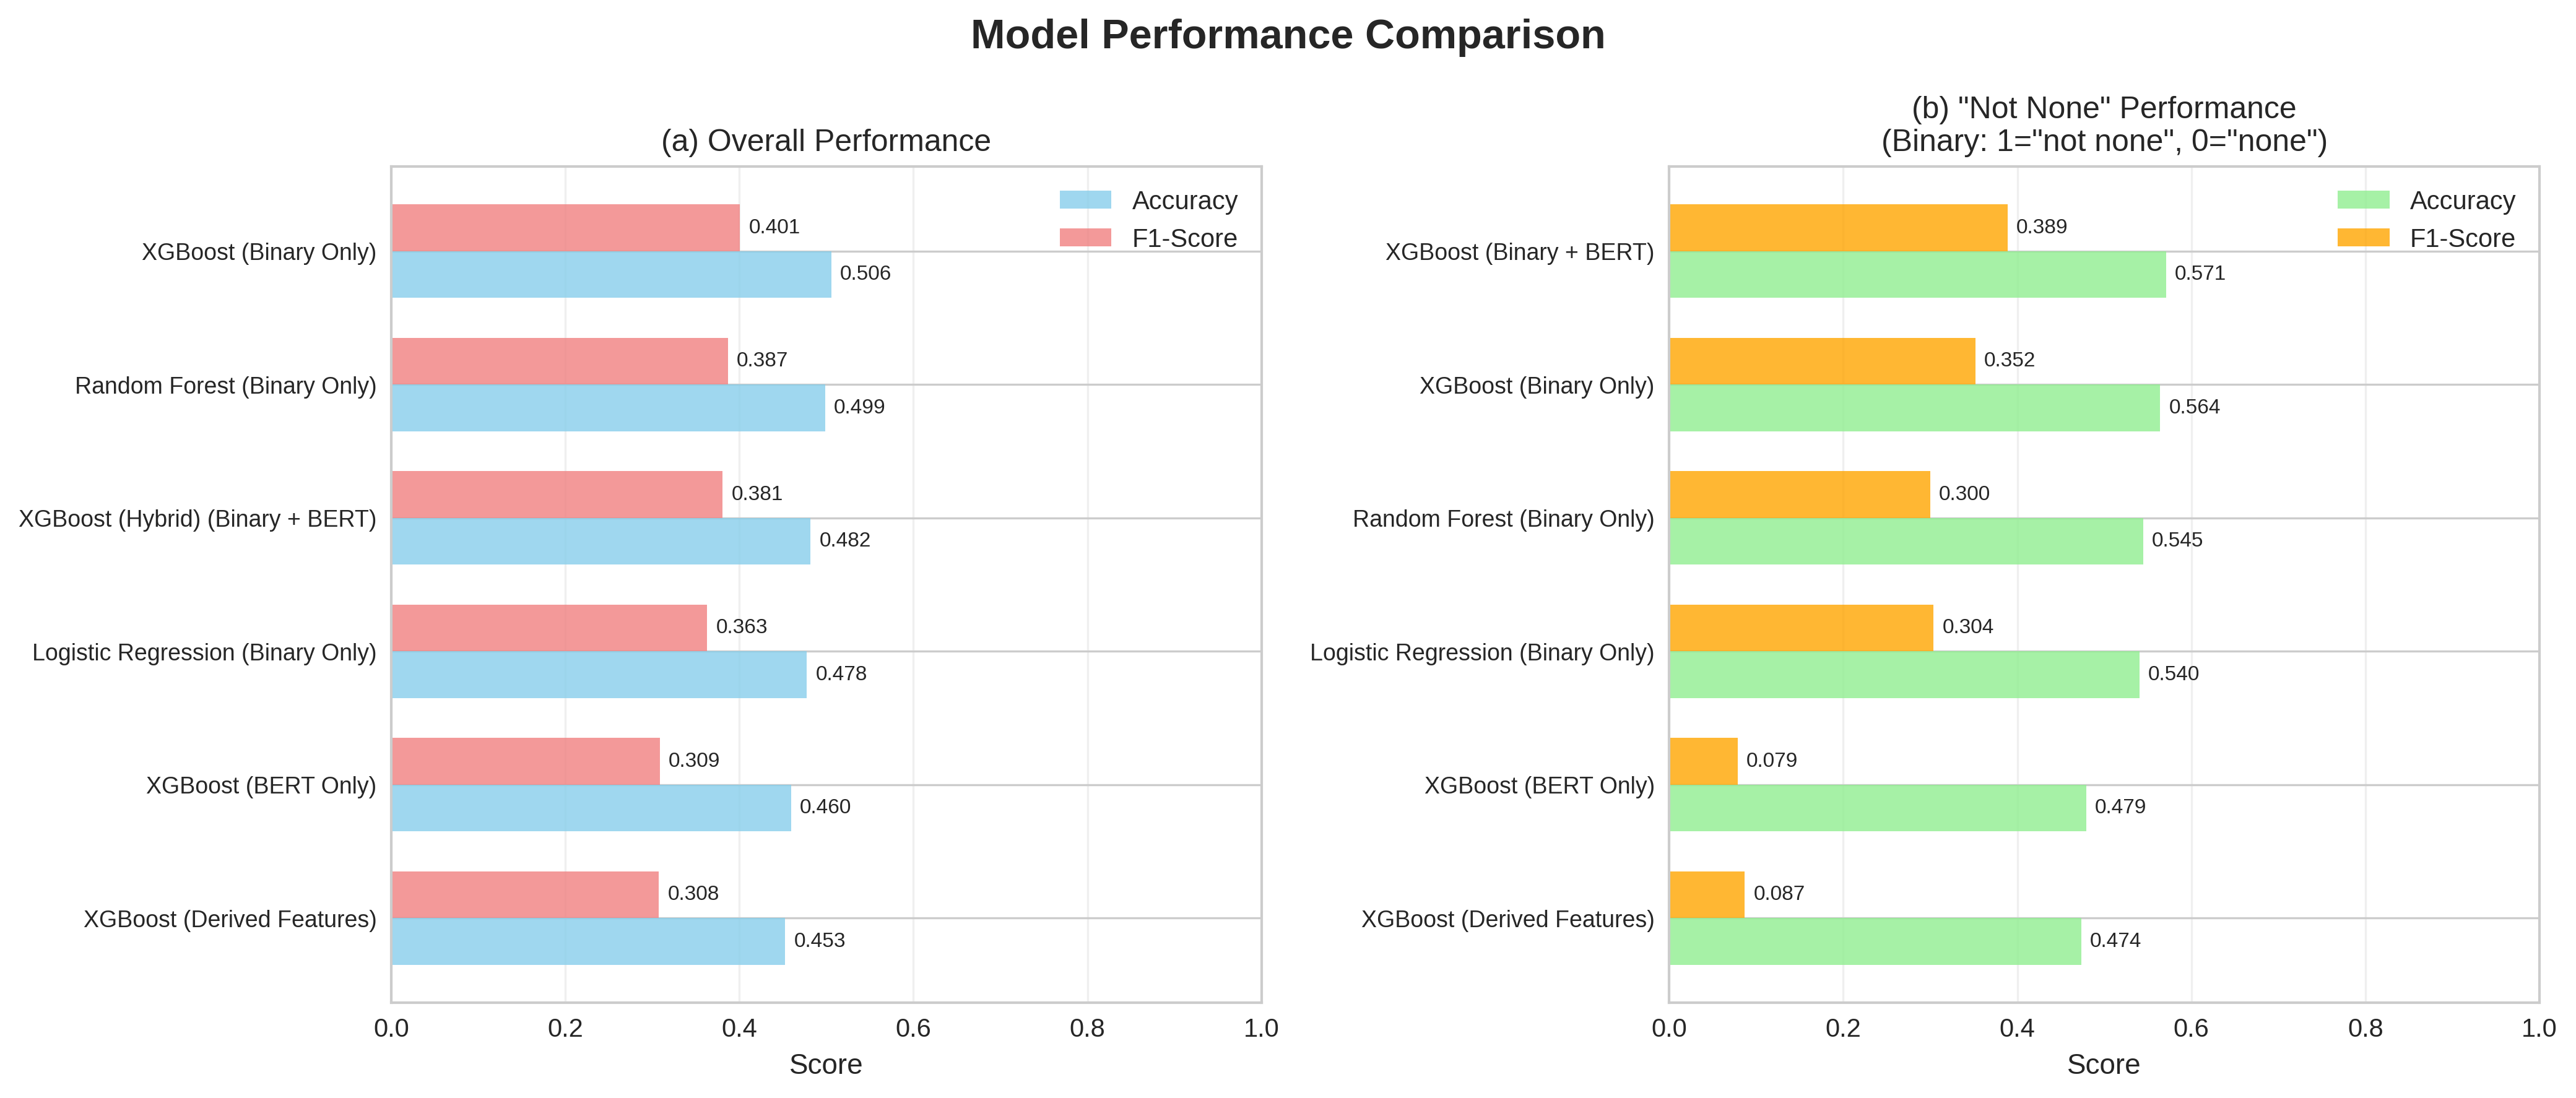


DETAILED PERFORMANCE COMPARISON TABLE

              Model         Features Overall Acc Overall F1 Not-None Acc Not-None F1 Sensitivity Specificity Precision
            XGBoost      Binary Only       0.506      0.401        0.564       0.352       0.226       0.936     0.794
      Random Forest      Binary Only       0.499      0.387        0.545       0.300       0.186       0.939     0.769
   XGBoost (Hybrid)    Binary + BERT       0.482      0.381        0.571       0.389       0.261       0.912     0.766
Logistic Regression      Binary Only       0.478      0.363        0.540       0.304       0.191       0.924     0.735
            XGBoost        BERT Only       0.460      0.309        0.479       0.079       0.043       0.959     0.533
            XGBoost Derived Features       0.453      0.308        0.474       0.087       0.048       0.942     0.474

✓ Detailed performance table saved to: ./fastfood_models/detailed_performance.csv

GRAPH GENERATION COMPLETE


In [42]:
import matplotlib.pyplot as plt
import numpy as np

print("\n📊 CREATING MODEL COMPARISON GRAPHS")
print("="*80)

# First, let's find which classes are "none-like"
none_classes = [cls for cls in label_encoder.classes_ if 'none' in cls.lower() or 'never' in cls.lower()]
if none_classes:
    none_class = none_classes[0]
    none_class_idx = label_encoder.transform([none_class])[0]
    print(f"Found 'none' class: {none_class} (index: {none_class_idx})")
else:
    print("No 'none' class found")
    none_class = None
    none_class_idx = None

# Prepare data for graphs
if 'results_df' in locals() and len(results_df) > 0:
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # Sort results for better visualization
    results_df_sorted = results_df.sort_values('Accuracy', ascending=True)
    models = results_df_sorted['Model'] + ' (' + results_df_sorted['Features'] + ')'
    
    # Bar positions
    x = np.arange(len(models))
    width = 0.35
    
    # Plot 1: Overall Accuracy and F1 Scores
    bars1 = ax1.barh(x - width/2, results_df_sorted['Accuracy'], width, label='Accuracy', color='skyblue', alpha=0.8)
    bars2 = ax1.barh(x + width/2, results_df_sorted['F1-Score'], width, label='F1-Score', color='lightcoral', alpha=0.8)
    
    ax1.set_xlabel('Score')
    ax1.set_title('(a) Overall Performance')
    ax1.set_yticks(x)
    ax1.set_yticklabels(models, fontsize=9)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.set_xlim([0, 1])
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            width_bar = bar.get_width()
            ax1.text(width_bar + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{width_bar:.3f}', ha='left', va='center', fontsize=8)
    
    # Plot 2: "Not None" Performance (if we have predictions)
    if none_class_idx is not None and 'xgb_combined_pred' in locals():
        print(f"\nCalculating 'not none' performance...")
        
        # Function to calculate "not none" performance
        def calculate_not_none_performance(y_true, y_pred, model_name):
            # Convert to binary: 1 = "not none", 0 = "none"
            y_true_binary = (y_true != none_class_idx).astype(int)
            y_pred_binary = (y_pred != none_class_idx).astype(int)
            
            # Calculate metrics
            if len(np.unique(y_true_binary)) > 1:  # Need both classes present
                acc = accuracy_score(y_true_binary, y_pred_binary)
                f1 = f1_score(y_true_binary, y_pred_binary)
            else:
                # If only one class present, accuracy is simple
                acc = accuracy_score(y_true_binary, y_pred_binary)
                f1 = 0
            
            return acc, f1
        
        # Calculate "not none" performance for each model
        not_none_accuracies = []
        not_none_f1_scores = []
        model_names = []
        
        # Collect predictions from all models
        all_predictions = {
            'Logistic Regression (Binary Only)': lr_pred if 'lr_pred' in locals() else None,
            'Random Forest (Binary Only)': rf_pred if 'rf_pred' in locals() else None,
            'XGBoost (Binary Only)': xgb_pred if 'xgb_pred' in locals() else None,
            'XGBoost (BERT Only)': xgb_bert_pred if 'xgb_bert_pred' in locals() else None,
            'XGBoost (Derived Features)': xgb_derived_pred if 'xgb_derived_pred' in locals() else None,
            'XGBoost (Binary + BERT)': xgb_combined_pred if 'xgb_combined_pred' in locals() else None,
        }
        
        for model_name, predictions in all_predictions.items():
            if predictions is not None and len(predictions) == len(y_test):
                acc, f1 = calculate_not_none_performance(y_test, predictions, model_name)
                not_none_accuracies.append(acc)
                not_none_f1_scores.append(f1)
                model_names.append(model_name)
                print(f"  {model_name:30}: Acc={acc:.3f}, F1={f1:.3f}")
        
        if model_names:  # Only plot if we have data
            # Sort by accuracy for consistency
            sorted_indices = np.argsort(not_none_accuracies)
            model_names_sorted = [model_names[i] for i in sorted_indices]
            acc_sorted = [not_none_accuracies[i] for i in sorted_indices]
            f1_sorted = [not_none_f1_scores[i] for i in sorted_indices]
            
            x2 = np.arange(len(model_names_sorted))
            
            bars3 = ax2.barh(x2 - width/2, acc_sorted, width, label='Accuracy', color='lightgreen', alpha=0.8)
            bars4 = ax2.barh(x2 + width/2, f1_sorted, width, label='F1-Score', color='orange', alpha=0.8)
            
            ax2.set_xlabel('Score')
            ax2.set_title(f'(b) "Not None" Performance\n(Binary: 1="not none", 0="{none_class}")')
            ax2.set_yticks(x2)
            ax2.set_yticklabels(model_names_sorted, fontsize=9)
            ax2.legend()
            ax2.grid(True, alpha=0.3, axis='x')
            ax2.set_xlim([0, 1])
            
            # Add value labels
            for bars in [bars3, bars4]:
                for bar in bars:
                    width_bar = bar.get_width()
                    ax2.text(width_bar + 0.01, bar.get_y() + bar.get_height()/2,
                            f'{width_bar:.3f}', ha='left', va='center', fontsize=8)
            
            # Add summary statistics
            print(f"\n📈 'NOT NONE' PERFORMANCE SUMMARY:")
            print("-" * 60)
            best_acc_idx = np.argmax(acc_sorted)
            best_f1_idx = np.argmax(f1_sorted)
            print(f"Best accuracy: {acc_sorted[best_acc_idx]:.3f} ({model_names_sorted[best_acc_idx]})")
            print(f"Best F1-score: {f1_sorted[best_f1_idx]:.3f} ({model_names_sorted[best_f1_idx]})")
            
            # Calculate class distribution
            y_test_binary = (y_test != none_class_idx).astype(int)
            none_count = sum(y_test_binary == 0)
            not_none_count = sum(y_test_binary == 1)
            total = len(y_test_binary)
            
            print(f"\nClass distribution in test set:")
            print(f"  '{none_class}': {none_count} samples ({none_count/total*100:.1f}%)")
            print(f"  'Not none': {not_none_count} samples ({not_none_count/total*100:.1f}%)")
        else:
            ax2.text(0.5, 0.5, 'No "not none"\nperformance data\navailable',
                    ha='center', va='center', fontsize=12)
            ax2.set_title('(b) "Not None" Performance')
            ax2.grid(False)
    else:
        ax2.text(0.5, 0.5, 'No "none" class\nidentified\nor predictions missing',
                ha='center', va='center', fontsize=12)
        ax2.set_title('(b) "Not None" Performance')
        ax2.grid(False)
    
    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(FastFoodConfig.SAVE_DIR, 'model_comparison_graphs.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Graphs saved to: {save_path}")
    plt.show()
    
    # Create a detailed performance table
    print("\n" + "="*80)
    print("DETAILED PERFORMANCE COMPARISON TABLE")
    print("="*80)
    
    # Create comprehensive table
    detailed_data = []
    for i, row in results_df.iterrows():
        model_name = row['Model']
        features = row['Features']
        
        # Get predictions for this model
        pred_key = None
        if model_name == 'Logistic Regression':
            pred_key = 'Logistic Regression (Binary Only)'
        elif model_name == 'Random Forest':
            pred_key = 'Random Forest (Binary Only)'
        elif model_name == 'XGBoost' and features == 'Binary Only':
            pred_key = 'XGBoost (Binary Only)'
        elif model_name == 'XGBoost' and features == 'BERT Only':
            pred_key = 'XGBoost (BERT Only)'
        elif model_name == 'XGBoost' and features == 'Derived Features':
            pred_key = 'XGBoost (Derived Features)'
        elif model_name == 'XGBoost (Hybrid)' and features == 'Binary + BERT':
            pred_key = 'XGBoost (Binary + BERT)'
        
        if pred_key and pred_key in all_predictions and all_predictions[pred_key] is not None:
            preds = all_predictions[pred_key]
            
            # Calculate overall confusion matrix
            cm = confusion_matrix(y_test, preds)
            
            # Calculate "not none" performance
            if none_class_idx is not None:
                y_true_binary = (y_test != none_class_idx).astype(int)
                y_pred_binary = (preds != none_class_idx).astype(int)
                
                # Confusion matrix for binary classification
                tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()
                
                # Calculate metrics
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                
                detailed_data.append({
                    'Model': model_name,
                    'Features': features,
                    'Overall Acc': f"{row['Accuracy']:.3f}",
                    'Overall F1': f"{row['F1-Score']:.3f}",
                    'Not-None Acc': f"{accuracy_score(y_true_binary, y_pred_binary):.3f}",
                    'Not-None F1': f"{f1_score(y_true_binary, y_pred_binary):.3f}",
                    'Sensitivity': f"{sensitivity:.3f}",
                    'Specificity': f"{specificity:.3f}",
                    'Precision': f"{precision:.3f}"
                })
            else:
                detailed_data.append({
                    'Model': model_name,
                    'Features': features,
                    'Overall Acc': f"{row['Accuracy']:.3f}",
                    'Overall F1': f"{row['F1-Score']:.3f}",
                    'Not-None Acc': 'N/A',
                    'Not-None F1': 'N/A',
                    'Sensitivity': 'N/A',
                    'Specificity': 'N/A',
                    'Precision': 'N/A'
                })
    
    if detailed_data:
        detailed_df = pd.DataFrame(detailed_data)
        print("\n" + detailed_df.to_string(index=False))
        
        # Save detailed table
        table_path = os.path.join(FastFoodConfig.SAVE_DIR, 'detailed_performance.csv')
        detailed_df.to_csv(table_path, index=False)
        print(f"\n✓ Detailed performance table saved to: {table_path}")
    
else:
    print("No results dataframe found for graphing")

print("\n" + "="*80)
print("GRAPH GENERATION COMPLETE")
print("="*80)